In [ ]:
import pandas as pd
df = pd.read_csv("relativeLengths.csv").set_index("Names")
print(df)
print(df["Index"].sum())
print(df["Index"].iloc[3])

             Index  Middle   Third  Fourth
Names                                     
METATOBASE  132.59  132.59  132.59  132.59
PIPTOMETA    30.19   33.22   28.72   22.89
DIPPIP       29.22   32.97   29.25   21.30
ENDDIP       31.95   33.81   33.84   30.70
223.95
31.95


In [10]:
import pyvista as pv
import numpy as np

topRadii = 5
bottomRadii = 3
fingerBodyHeight = 10
fingerBodyWidth = 13
fingerBodyLength = 20
resolution = 16
stringHoleRadius = 0.7

connectorThickness = 1
connectorRadius = 1.2
connectorLength = 4
connectorDistanceBelowMidline = 1.5


def generateFingerPartWithConnectorCut(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, stringHoleRadius, 
                       fingerBodyLength, connectorRadius, connectorLength, 
                       connectorThickness, connectorDistanceBelowMidline):

    def endFaceTop(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        newPoints.append((0,0,0))
        offset = len(newPoints)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta), holeRadius*np.sin(theta)+fingerBodyHeight/4, holeRadius*np.sin(theta)+fingerBodyHeight/4)) 
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    def endFaceBottom(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        return np.array(newPoints)
    
    def createConnector(endRadius, length, thickness, connectorDistanceBelowMidline, resolutionBody=8, resolutionEnd=8):
        verticesTop = []
        verticesBottom = []
        verticesTop.append((0, thickness/2, 0))
        verticesTop.append((0, thickness/2, length/2))
        currTheta = np.pi-np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*currTheta/(resolutionEnd+1)
        currTheta-=thetaInterval
        for _ in range(int(resolutionEnd/2)):
            verticesTop.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)+length/2+endRadius))
            verticesBottom.append((0, endRadius*np.sin(currTheta-thetaInterval*(int(resolutionEnd/2))), endRadius*np.cos(currTheta-thetaInterval*(int(resolutionEnd/2)))+length/2+endRadius))
            currTheta -= thetaInterval
        for i, vertex in enumerate(verticesTop):
            verticesTop[i]= (vertex[0], vertex[1]-connectorDistanceBelowMidline, vertex[2])
        verticesBottom.append((0, -thickness/2, length/2))
        verticesBottom.append((0, -thickness/2, 0))
        
        for i, vertex in enumerate(verticesBottom):
            verticesBottom[i]= (vertex[0], vertex[1]-connectorDistanceBelowMidline, vertex[2])
    
        return verticesTop, verticesBottom
    
    totalVerts = []
    totalFaces = []
    frontVerticesTop, facesFrontTop = endFaceTop(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=stringHoleRadius)
    frontVerticesBottom = endFaceBottom(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=stringHoleRadius)
    vertsLeftTop, vertsLeftBottom = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, connectorDistanceBelowMidline=connectorDistanceBelowMidline)
    for i, vertex in enumerate(vertsLeftTop):
        vertsLeftTop[i]= (vertex[0]-fingerBodyWidth/2, vertex[1], vertex[2])
    for i, vertex in enumerate(vertsLeftBottom):
        vertsLeftBottom[i]= (vertex[0]-fingerBodyWidth/2, vertex[1], vertex[2])
    vertsRightTop, vertsRightBottom = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, connectorDistanceBelowMidline=connectorDistanceBelowMidline)
    for i, vertex in enumerate(vertsRightTop):
        vertsRightTop[i]= (vertex[0]+fingerBodyWidth/2, vertex[1], vertex[2])
    for i, vertex in enumerate(vertsRightBottom):
        vertsRightBottom[i]= (vertex[0]+fingerBodyWidth/2, vertex[1], vertex[2])
    pl = pv.Plotter()
    totalVerts.extend(frontVerticesTop)
    totalVerts.extend(frontVerticesBottom)
    totalFaces.extend(facesFrontTop)
    backWall = []
    for vertice in frontVerticesTop:
        backWall.append((vertice[0], vertice[1], fingerBodyLength/2))
    for vertice in frontVerticesBottom:
        backWall.append((vertice[0], vertice[1], fingerBodyLength/2))
    totalVerts.extend(backWall)
    offset = len(frontVerticesBottom)+len(frontVerticesTop)
    for face in facesFrontTop:
        totalFaces.append((face[0], face[1]+offset, face[2]+offset, face[3]+offset))
    for idx in range(1, len(frontVerticesTop)-1):
        if idx!=resolution+1:
            totalFaces.append((3, idx, idx+1, idx+offset))
            totalFaces.append((3, idx+offset, idx+offset+1, idx+1))
    offset = 2*len(frontVerticesTop)+len(frontVerticesBottom)
    for idx in range(0, len(frontVerticesBottom)-1):
        totalFaces.append((3, idx+offset, idx+1+offset, len(frontVerticesBottom)-1+offset))
    offset = len(frontVerticesTop)
    for idx in range(0, len(frontVerticesBottom)-1):
        totalFaces.append((3, idx+offset, idx+1+offset, len(frontVerticesBottom)-1+offset))
    offset1 = len(frontVerticesTop)
    offset2 = 2*len(frontVerticesTop)+len(frontVerticesBottom)
    for idx in range(0, len(frontVerticesBottom)-1):
        totalFaces.append((3, idx+offset1, idx+1+offset1, idx+offset2))
        totalFaces.append((3, idx+offset2, idx+offset2+1, idx+1+offset1))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, 2*len(frontVerticesTop)+len(frontVerticesBottom), len(frontVerticesTop)+len(frontVerticesBottom)+1))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, 2*len(frontVerticesTop)+len(frontVerticesBottom), 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1))
    offset=len(totalVerts)
    totalVerts.extend(vertsLeftTop)
    totalVerts.extend(vertsLeftBottom)
    totalVerts.extend(vertsRightTop)
    totalVerts.extend(vertsRightBottom)

    totalFaces.append((3, 0, offset+len(vertsLeftTop)+len(vertsLeftBottom), 1))
    totalFaces.append((3, 0, offset+len(vertsLeftTop)+len(vertsLeftBottom), offset))
    totalFaces.append((3, 0, offset, resolution+1))

    totalFaces.append((3, len(frontVerticesTop), offset+2*len(vertsLeftTop)+2*len(vertsLeftBottom)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))
    totalFaces.append((3, offset+len(vertsLeftTop)+len(vertsLeftBottom)-1, offset+2*len(vertsLeftTop)+2*len(vertsLeftBottom)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))

    for idx in range(len(vertsLeftTop)+len(vertsLeftBottom)-1):
        totalFaces.append((3, idx+offset, idx+1+offset, idx+offset+len(vertsLeftTop)+len(vertsLeftBottom)+1))
        totalFaces.append((3, idx+offset, idx+offset+len(vertsLeftTop)+len(vertsLeftBottom), idx+offset+len(vertsLeftTop)+len(vertsLeftBottom)+1))
    
    #SIDEWALLS
    otherSide = len(vertsLeftTop)+len(vertsLeftBottom)
    for idx in range(1, int(len(vertsLeftTop)/2)+1):
        totalFaces.append((3, offset+idx-1, resolution+1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, 1, offset+idx+otherSide))
    totalFaces.append((3, resolution+1, offset+int(len(vertsLeftTop)/2), len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1))
    totalFaces.append((3, 1, offset+int(len(vertsLeftTop)/2)+otherSide, len(frontVerticesTop)+len(frontVerticesBottom)+1))
    for idx in range(int(len(vertsLeftTop)/2)+1, len(vertsLeftTop)):
        totalFaces.append((3, offset+idx-1, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, len(frontVerticesTop)+len(frontVerticesBottom)+1, offset+idx+otherSide))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, offset+len(vertsLeftTop)-1, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+1, offset+len(vertsLeftTop)-1+otherSide, 2*len(frontVerticesTop)+len(frontVerticesBottom)))
    #BOTTOM HALF
    for idx in range(len(vertsLeftTop), len(vertsLeftTop)+int(len(vertsLeftBottom)/2)):
        totalFaces.append((3, offset+idx-1, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, 2*len(frontVerticesTop)+len(frontVerticesBottom), offset+idx+otherSide))
    totalFaces.append((3, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1, offset+len(vertsLeftTop)+int(len(vertsLeftBottom)/2)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))
    totalFaces.append((3, 2*len(frontVerticesTop)+len(frontVerticesBottom), offset+len(vertsLeftTop)+int(len(vertsLeftBottom)/2)-1+otherSide, len(frontVerticesTop)))
    for idx in range(len(vertsLeftTop)+int(len(vertsLeftBottom)/2), len(vertsLeftTop)+len(vertsLeftBottom)):
        totalFaces.append((3, offset+idx-1, len(frontVerticesTop)+len(frontVerticesBottom)-1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, len(frontVerticesTop), offset+idx+otherSide))
    mesh = pv.PolyData(totalVerts, totalFaces).clean().triangulate()
    half2 = mesh.reflect((0, 0, 1), point=(0, 0, fingerBodyLength/2))
    merged = half1.merge(half2)
    cleanedMerge = merged.clean()
    return cleanedMerge

half1 = generateFingerPartWithConnectorCut(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, 
                            fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, 
                            stringHoleRadius=stringHoleRadius, fingerBodyLength=fingerBodyLength, 
                            connectorRadius=connectorRadius, connectorLength=connectorLength, connectorThickness=connectorThickness, 
                            connectorDistanceBelowMidline=connectorDistanceBelowMidline)
half1.plot_normals()
# p = pv.Plotter()
# p.add_mesh(cleanedMerge)
# p.show()

Widget(value="<iframe src='http://localhost:63083/index.html?ui=P_0x21eb946e3b0_17&reconnect=auto' style='widt…

In [4]:
import pyvista as pv
import numpy as np

topRadii = 5
bottomRadii = 3
fingerBodyHeight = 10
fingerBodyWidth = 13
fingerBodyLength = 20
resolution = 16
stringHoleRadius = 0.7

connectorThickness = 1
connectorRadius = 1.2
connectorLength = 4
connectorDistanceBelowMidline = 1.5


def generateFingerPartWithConnectorCut(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, stringHoleRadius, 
                       fingerBodyLength, connectorRadius, connectorLength, 
                       connectorThickness, connectorDistanceBelowMidline):

    def endFaceTop(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        newPoints.append((0,0,0))
        offset = len(newPoints)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta), holeRadius*np.sin(theta)+fingerBodyHeight/4, holeRadius*np.sin(theta)+fingerBodyHeight/4)) 
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    def endFaceBottom(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        return np.array(newPoints)
    
    def createConnector(endRadius, length, thickness, connectorDistanceBelowMidline, resolutionBody=8, resolutionEnd=8):
        verticesTop = []
        verticesBottom = []
        verticesTop.append((0, thickness/2, 0))
        verticesTop.append((0, thickness/2, length/2))
        currTheta = np.pi-np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*currTheta/(resolutionEnd+1)
        currTheta-=thetaInterval
        for _ in range(int(resolutionEnd/2)):
            verticesTop.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)+length/2+endRadius))
            verticesBottom.append((0, endRadius*np.sin(currTheta-thetaInterval*(int(resolutionEnd/2))), endRadius*np.cos(currTheta-thetaInterval*(int(resolutionEnd/2)))+length/2+endRadius))
            currTheta -= thetaInterval
        for i, vertex in enumerate(verticesTop):
            verticesTop[i]= (vertex[0], vertex[1]-connectorDistanceBelowMidline, vertex[2])
        verticesBottom.append((0, -thickness/2, length/2))
        verticesBottom.append((0, -thickness/2, 0))
        
        for i, vertex in enumerate(verticesBottom):
            verticesBottom[i]= (vertex[0], vertex[1]-connectorDistanceBelowMidline, vertex[2])
    
        return verticesTop, verticesBottom
    
    totalVerts = []
    totalFaces = []
    frontVerticesTop, facesFrontTop = endFaceTop(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=stringHoleRadius)
    frontVerticesBottom = endFaceBottom(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=stringHoleRadius)
    vertsLeftTop, vertsLeftBottom = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, connectorDistanceBelowMidline=connectorDistanceBelowMidline)
    for i, vertex in enumerate(vertsLeftTop):
        vertsLeftTop[i]= (vertex[0]-fingerBodyWidth/2, vertex[1], vertex[2])
    for i, vertex in enumerate(vertsLeftBottom):
        vertsLeftBottom[i]= (vertex[0]-fingerBodyWidth/2, vertex[1], vertex[2])
    vertsRightTop, vertsRightBottom = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, connectorDistanceBelowMidline=connectorDistanceBelowMidline)
    for i, vertex in enumerate(vertsRightTop):
        vertsRightTop[i]= (vertex[0]+fingerBodyWidth/2, vertex[1], vertex[2])
    for i, vertex in enumerate(vertsRightBottom):
        vertsRightBottom[i]= (vertex[0]+fingerBodyWidth/2, vertex[1], vertex[2])
    pl = pv.Plotter()
    totalVerts.extend(frontVerticesTop)
    totalVerts.extend(frontVerticesBottom)
    totalFaces.extend(facesFrontTop)
    backWall = []
    for vertice in frontVerticesTop:
        backWall.append((vertice[0], vertice[1], fingerBodyLength/2))
    for vertice in frontVerticesBottom:
        backWall.append((vertice[0], vertice[1], fingerBodyLength/2))
    totalVerts.extend(backWall)
    offset = len(frontVerticesBottom)+len(frontVerticesTop)

    for idx in range(1, len(frontVerticesTop)-1):
        if idx!=resolution+1:
            totalFaces.append((3, idx, idx+1, idx+offset))
            totalFaces.append((3, idx+offset, idx+offset+1, idx+1))

    offset = len(frontVerticesTop)
    for idx in range(0, len(frontVerticesBottom)-1):
        totalFaces.append((3, idx+offset, idx+1+offset, len(frontVerticesBottom)-1+offset))
    offset1 = len(frontVerticesTop)
    offset2 = 2*len(frontVerticesTop)+len(frontVerticesBottom)
    for idx in range(0, len(frontVerticesBottom)-1):
        totalFaces.append((3, idx+offset1, idx+1+offset1, idx+offset2))
        totalFaces.append((3, idx+offset2, idx+offset2+1, idx+1+offset1))
  
    offset=len(totalVerts)

    totalVerts.extend(vertsLeftTop)
    totalVerts.extend(vertsLeftBottom)
    totalVerts.extend(vertsRightTop)
    totalVerts.extend(vertsRightBottom)

    totalFaces.append((3, 0, offset+len(vertsLeftTop)+len(vertsLeftBottom), 1))
    totalFaces.append((3, 0, offset+len(vertsLeftTop)+len(vertsLeftBottom), offset))
    totalFaces.append((3, 0, offset, resolution+1))

    totalFaces.append((3, len(frontVerticesTop), offset+2*len(vertsLeftTop)+2*len(vertsLeftBottom)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))
    totalFaces.append((3, offset+len(vertsLeftTop)+len(vertsLeftBottom)-1, offset+2*len(vertsLeftTop)+2*len(vertsLeftBottom)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))

    for idx in range(len(vertsLeftTop)+len(vertsLeftBottom)-1):
        totalFaces.append((3, idx+offset, idx+1+offset, idx+offset+len(vertsLeftTop)+len(vertsLeftBottom)+1))
        totalFaces.append((3, idx+offset, idx+offset+len(vertsLeftTop)+len(vertsLeftBottom), idx+offset+len(vertsLeftTop)+len(vertsLeftBottom)+1))
    
    #SIDEWALLS
    otherSide = len(vertsLeftTop)+len(vertsLeftBottom)
    for idx in range(1, int(len(vertsLeftTop)/2)+1):
        totalFaces.append((3, offset+idx-1, resolution+1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, 1, offset+idx+otherSide))
    totalFaces.append((3, resolution+1, offset+int(len(vertsLeftTop)/2), len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1))
    totalFaces.append((3, 1, offset+int(len(vertsLeftTop)/2)+otherSide, len(frontVerticesTop)+len(frontVerticesBottom)+1))
    for idx in range(int(len(vertsLeftTop)/2)+1, len(vertsLeftTop)):
        totalFaces.append((3, offset+idx-1, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, len(frontVerticesTop)+len(frontVerticesBottom)+1, offset+idx+otherSide))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+resolution+1, offset+len(vertsLeftTop)-1, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1))
    totalFaces.append((3, len(frontVerticesTop)+len(frontVerticesBottom)+1, offset+len(vertsLeftTop)-1+otherSide, 2*len(frontVerticesTop)+len(frontVerticesBottom)))
    #BOTTOM HALF
    for idx in range(len(vertsLeftTop), len(vertsLeftTop)+int(len(vertsLeftBottom)/2)):
        totalFaces.append((3, offset+idx-1, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, 2*len(frontVerticesTop)+len(frontVerticesBottom), offset+idx+otherSide))
    totalFaces.append((3, 2*len(frontVerticesTop)+2*len(frontVerticesBottom)-1, offset+len(vertsLeftTop)+int(len(vertsLeftBottom)/2)-1, len(frontVerticesTop)+len(frontVerticesBottom)-1))
    totalFaces.append((3, 2*len(frontVerticesTop)+len(frontVerticesBottom), offset+len(vertsLeftTop)+int(len(vertsLeftBottom)/2)-1+otherSide, len(frontVerticesTop)))
    for idx in range(len(vertsLeftTop)+int(len(vertsLeftBottom)/2), len(vertsLeftTop)+len(vertsLeftBottom)):
        totalFaces.append((3, offset+idx-1, len(frontVerticesTop)+len(frontVerticesBottom)-1, offset+idx))
        totalFaces.append((3, offset+idx-1+otherSide, len(frontVerticesTop), offset+idx+otherSide))
    print(totalVerts)
    for idx, point in enumerate(totalVerts):
        totalVerts[idx] = np.array(point) - np.array([0, 0, fingerBodyLength / 2])
    print(totalVerts)
    mesh = pv.PolyData(totalVerts, totalFaces).clean().triangulate()
    half2 = mesh.reflect((0, 0, 1), point=(0, 0, 0))
    merged = mesh.merge(half2)
    cleanedMerge = merged.clean()
    return cleanedMerge

half1 = generateFingerPartWithConnectorCut(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, 
                            fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, 
                            stringHoleRadius=stringHoleRadius, fingerBodyLength=fingerBodyLength, 
                            connectorRadius=connectorRadius, connectorLength=connectorLength, connectorThickness=connectorThickness, 
                            connectorDistanceBelowMidline=connectorDistanceBelowMidline)
half1.plot()
half1.save('thingyyy.stl')
# p = pv.Plotter()
# p.add_mesh(cleanedMerge)
# p.show()

[array([0., 0., 0.]), array([6.5, 0. , 0. ]), array([6.37510432, 1.26808709, 1.26808709]), array([6.00521696, 2.48744231, 2.48744231]), array([5.40455248, 3.61120651, 3.61120651]), array([4.59619408, 4.59619408, 4.59619408]), array([3.34089319, 5.        , 5.        ]), array([2.07106781, 5.        , 5.        ]), array([0.99456184, 5.        , 5.        ]), array([3.061617e-16, 5.000000e+00, 5.000000e+00]), array([-0.99456184,  5.        ,  5.        ]), array([-2.07106781,  5.        ,  5.        ]), array([-3.34089319,  5.        ,  5.        ]), array([-4.59619408,  4.59619408,  4.59619408]), array([-5.40455248,  3.61120651,  3.61120651]), array([-6.00521696,  2.48744231,  2.48744231]), array([-6.37510432,  1.26808709,  1.26808709]), array([-6.5,  0. ,  0. ]), array([-1.28587914e-16,  1.80000000e+00,  1.80000000e+00]), array([0.2678784 , 1.85328433, 1.85328433]), array([0.49497475, 2.00502525, 2.00502525]), array([0.64671567, 2.2321216 , 2.2321216 ]), array([0.7, 2.5, 2.5]), array(

Widget(value="<iframe src='http://localhost:50563/index.html?ui=P_0x230b1bab970_4&reconnect=auto' style='width…

NotImplementedError: Unable to wrap (<class 'str'>) into a pyvista type.

HERE

In [1]:
from vtkbool.vtkBool import vtkPolyDataBooleanFilter
import numpy as np
import pyvista as pv
def createBaseConnector(
    baseRadius, connectorWidth, connectorHeight, pieceHeight
):
    resolution = 30
    connectorWidth /= 2
    connectorHeight += 2  # this is basically the minor axiso f the uper ellipse
    pieceHeight += 3
    bottomPoints = []
    thetaInterval = 2 * np.pi / resolution
    for i in range(resolution):
        bottomPoints.append(
            (
                baseRadius * np.cos(thetaInterval * i),
                baseRadius * np.sin(thetaInterval * i),
                pieceHeight,
            )
        )
    bottomPoints.append((0, 0, pieceHeight))
    topPoints = []
    for i in range(resolution):
        topPoints.append(
            (
                connectorWidth * np.cos(thetaInterval * i),
                connectorHeight * np.sin(thetaInterval * i),
                0,
            )
        )
    topPoints.append((0, 0, 0))
    totalFaces = []
    for i in range(len(bottomPoints) - 1):
        totalFaces.append(
            (3, len(bottomPoints) - 1, i, (i + 1) % (len(bottomPoints) - 1))
        )
    bottomPoints.extend(topPoints)
    offset = len(topPoints)
    for i in range(len(topPoints) - 1):
        totalFaces.append(
            (
                3,
                len(topPoints) - 1 + offset,
                i + offset,
                (i + 1) % (len(topPoints) - 1) + offset,
            )
        )
    for i in range(resolution):
        totalFaces.append((3, i, (i + 1) % resolution, i + offset))
        totalFaces.append(
            (3, i + offset, (i + 1) % resolution + offset, (i + 1) % resolution)
        )
    mesh = pv.PolyData(bottomPoints, totalFaces).triangulate()
    return mesh.compute_normals(consistent_normals=True, auto_orient_normals=True)

def createConnectorHalf(
    endRadius, length, thickness, resolutionEnd=8, width=6
):
    vertices = []
    totalFaces = []
    vertices.append((0, thickness / 2, 0))
    vertices.append((0, thickness / 2, length / 2))
    vertices.append((0, -thickness / 2, length / 2))
    vertices.append((0, -thickness / 2, 0))

    totalFaces.append((3, 0, 1, 2))
    totalFaces.append((3, 2, 3, 0))

    currTheta = np.pi - np.arcsin(thickness / 2 / endRadius)
    thetaInterval = 2 * currTheta / (resolutionEnd + 1)
    currTheta -= thetaInterval
    for _ in range(resolutionEnd):
        vertices.append(
            (
                0,
                endRadius * np.sin(currTheta),
                endRadius * np.cos(currTheta) + length / 2 + endRadius,
            )
        )
        currTheta -= thetaInterval
    vertices.append((0, 0, length / 2 + endRadius))
    offset = 4
    for i in range(resolutionEnd):
        totalFaces.append((3, i + offset, len(vertices) - 1, i + 1 + offset))

    totalFaces.append((3, 1, len(vertices) - 1, 2))
    totalFaces.append((3, 1, len(vertices) - 1, 4))
    totalFaces.append((3, 4 + resolutionEnd - 1, len(vertices) - 1, 2))

    return vertices, totalFaces

def createFullConnector(endRadius, length, thickness, resolutionEnd, width):
    length = length / 2 + 1
    half1Vert, half1Face = createConnectorHalf(
        endRadius=endRadius,
        length=length,
        thickness=thickness,
        resolutionEnd=resolutionEnd,
    )
    half2Vert, half2Face = createConnectorHalf(
        endRadius=endRadius,
        length=length,
        thickness=thickness,
        resolutionEnd=resolutionEnd,
    )
    for i, vert in enumerate(half2Vert):
        half2Vert[i] = (vert[0] - width / 2, vert[1], vert[2])
    for i, vert in enumerate(half1Vert):
        half1Vert[i] = (vert[0] + width / 2, vert[1], vert[2])
    offset = len(half1Vert)
    for i, face in enumerate(half2Face):
        half2Face[i] = (3, face[1] + offset, face[2] + offset, face[3] + offset)
    totalVerts = []
    totalFaces = []
    totalVerts.extend(half1Vert)
    totalVerts.extend(half2Vert)
    totalFaces.extend(half1Face)
    totalFaces.extend(half2Face)

    totalFaces.append((3, 0, 1, offset))
    totalFaces.append((3, 1, offset + 1, offset))

    totalFaces.append((3, 2, 3, offset + 3))
    totalFaces.append((3, 2, offset + 2, offset + 3))

    totalFaces.append((3, 0, offset, 3))
    totalFaces.append((3, offset + 3, offset, 3))

    for i in range(resolutionEnd - 1):
        totalFaces.append((3, i + 4, i + 5, i + 4 + offset))
        totalFaces.append((3, i + 4 + offset, i + 5 + offset, i + 5))

    totalFaces.append((3, 1, 1 + offset, 4 + offset))
    totalFaces.append((3, 4 + offset, 4, 1))

    totalFaces.append((3, 2, 2 + offset, 3 + offset + resolutionEnd))
    totalFaces.append((3, 3 + offset + resolutionEnd, 3 + resolutionEnd, 2))

    for i, point in enumerate(totalVerts):
        totalVerts[i] = point + np.array([0, 0, -1])

    mesh = (
        pv.PolyData(totalVerts, totalFaces)
        .compute_normals(
            non_manifold_traversal=False,
            consistent_normals=True,
            auto_orient_normals=True,
        )
        .clean()
        .triangulate()
    )
    return mesh

def createConnectionBetweenFingerAndSocket(
    baseRadius,
    connectorWidth,
    connectorThickness,
    connectorLength,
    connectorRadius,
):
    resolutionEnd = 12
    base = createBaseConnector(
        baseRadius=baseRadius,
        connectorWidth=connectorWidth,
        connectorHeight=connectorThickness,
        pieceHeight=connectorLength,
    )
    connector = createFullConnector(
        width=connectorWidth * 3,
        endRadius=connectorRadius,
        length=connectorLength,
        thickness=connectorThickness,
        resolutionEnd=resolutionEnd,
    )
    boolean = vtkPolyDataBooleanFilter()
    boolean.SetInputData(0, base)
    boolean.SetInputData(1, connector)
    boolean.SetOperModeToDifference()
    boolean.Update()
    return pv.wrap(boolean.GetOutput())

def moveAlignMesh(mesh, newCenter, newAlignVector, newNormal):
    otherNormal = np.cross(newAlignVector, newNormal)
    v1 = otherNormal / np.linalg.norm(otherNormal)
    v2 = newNormal / np.linalg.norm(newNormal) * -1
    v3 = newAlignVector / np.linalg.norm(newAlignVector)
    if (
        not np.allclose(np.dot(v1, v2), 0)
        or not np.allclose(np.dot(v1, v3), 0)
        or not np.allclose(np.dot(v2, v3), 0)
    ):
        raise ValueError("Basis vectors are not orthogonal")
    transformation_matrix = np.column_stack((v1, v2, v3))
    finalTransformation = np.eye(4)
    finalTransformation[0:3, 0:3] = transformation_matrix
    mesh = mesh.transform(finalTransformation)
    translation_vector = newCenter - np.array([0, 0, 0], dtype=float)
    mesh = mesh.translate(translation_vector)
    return mesh
initRadius = 12
connectorPiece = createConnectionBetweenFingerAndSocket(
    baseRadius=initRadius,
    connectorWidth=10,
    connectorThickness=1,
    connectorLength=4,
    connectorRadius=1.2,
)

crossedBiNormal = np.cross(np.array([3, 0, 0]), np.array([0, 3, 5]))
connectorPiece = moveAlignMesh(
    connectorPiece, np.array([5, 2, 3]), crossedBiNormal, np.array([3, 0, 0])
)
connectorPiece.plot()

Widget(value="<iframe src='http://localhost:50563/index.html?ui=P_0x230abb9a9b0_0&reconnect=auto' style='width…

0.04068390461516007
Center (h, k): (-0.012470795164651076, -0.0026606215370784158)
Semi-major axis (a): 2.721589481565398
Semi-minor axis (b): 2.0418198639295833
Rotation angle (phi, in radians): 1.2757834784951996
Rotation angle (phi, in degrees): 73.09700889029416
[[ 0.15050167 -2.86096791]
 [ 0.13475615 -2.85953177]
 [ 0.11705686 -2.85790068]
 [ 0.08361204 -2.85457853]
 [ 0.05016722 -2.85101962]]


C:\Users\Katie\AppData\Local\Temp\ipykernel_31956\1216255683.py:61: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  paths = contour.collections[0].get_paths()


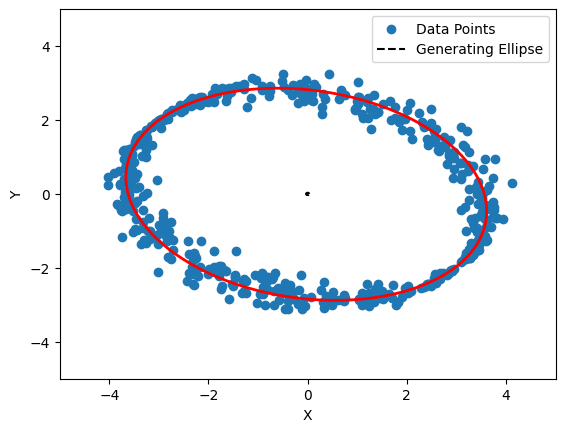

In [51]:
import numpy as np
import matplotlib.pyplot as plt
alpha = 5
beta = 3
N = 500
DIM = 2

np.random.seed(2)

# Generate random points on the unit circle by sampling uniform angles
theta = np.random.uniform(0, 2*np.pi, (N,1))
eps_noise = 0.2 * np.random.normal(size=[N,1])
circle = np.hstack([np.cos(theta), np.sin(theta)])
B = np.random.randint(-3, 3, (DIM, DIM))
noisy_ellipse = circle.dot(B) + eps_noise

# Extract x coords and y coords of the ellipse as column vectors
X = noisy_ellipse[:,0:1]
Y = noisy_ellipse[:,1:]
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()
A = x[0]
B = x[1]
C = x[2]
D = x[3]
E = x[4]
F=-1
term = np.sqrt((A-C)**2 + B**2)
h = (C*D - B*E) / (B**2 - 4*A*C)
k = (A*E - B*D) / (B**2 - 4*A*C)

a = np.sqrt(2 * (A*E**2 + C*D**2 + B*D*E - 2*A*C*F - B**2*F) /
            ((B**2 - 4*A*C) * (term - (A+C))))
b = np.sqrt(2 * (A*E**2 + C*D**2 + B*D*E - 2*A*C*F - B**2*F) /
            ((B**2 - 4*A*C) * (-term - (A+C))))
phi = 0.5 * np.arctan2(B, A-C)

print("Center (h, k):", (h, k))
print("Semi-major axis (a):", a)
print("Semi-minor axis (b):", b)
print("Rotation angle (phi, in radians):", phi)
print("Rotation angle (phi, in degrees):", np.degrees(phi))


plt.scatter(X, Y, label='Data Points')

# Plot the original ellipse from which the data was generated
phi = np.linspace(0, 2*np.pi, 1000).reshape((1000,1))
c = np.hstack([np.cos(phi), np.sin(phi)])
ground_truth_ellipse = c.dot(B)
plt.plot(ground_truth_ellipse[:,0], ground_truth_ellipse[:,1], 'k--', label='Generating Ellipse')


x_coord = np.linspace(-5,5,300)
y_coord = np.linspace(-5,5,300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
contour = plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
paths = contour.collections[0].get_paths()
path = paths[0]
vertices = path.vertices
print(vertices[:5])

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


In [11]:
import pyvista as pv
sphere = pv.Sphere(radius=0.2)
point, cell = sphere.ray_trace(
    [0, 0, 0], [1, 0, 0], first_point=True
)
f'Intersected at {point[0]:.3f} {point[1]:.3f} {point[2]:.3f}'

'Intersected at 0.200 0.000 0.000'

In [7]:
import pyvista as pv
import numpy as np
s1 = pv.Sphere(phi_resolution=15, theta_resolution=15)
s2 = pv.Plane(i_size=20, j_size=20).triangulate()
intersection, s1_split, s2_split = s1.intersection(s2)
p = pv.Plotter()
p.add_mesh(s1)
p.add_mesh(s2)
p.add_mesh(intersection)
p.show()

Widget(value="<iframe src='http://localhost:56962/index.html?ui=P_0x1ff18943eb0_2&reconnect=auto' style='width…

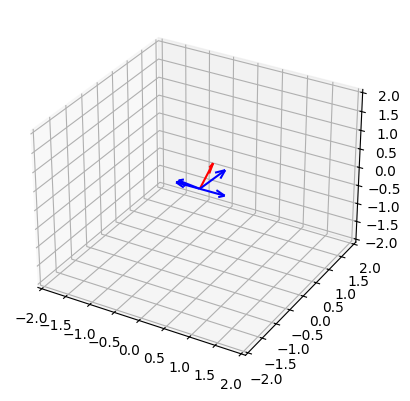

In [25]:
thing = np.array([-7.85946773, 27.12302379, -1.1188804 ])
thing = thing/np.linalg.norm(thing)
others  = np.array([[ 0.5795875,  -0.13146546,  0.80423576], [-0.7441641,   0.528464,   -0.40858975], [ 0.7657304,  -0.4767234,   0.43173116], [-0.76594734,  0.4761563,  -0.43197215]])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

soa = np.array([[0, 0, 1, 1, -2, 0], [0, 0, 2, 1, 1, 0],
                [0, 0, 3, 2, 1, 0], [0, 0, 4, 0.5, 0.7, 0]])

U,V, W= zip(*others)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(0, 0, 0, U, V, W, color="b")
ax.quiver(0, 0, 0, thing[0], thing[1], thing[2], color="r")
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
plt.show()



In [16]:
import pyvista as pv
import numpy as np
baseRadius = 12
connectorWidth = 10
connectorHeight = 5
pieceHeight = 4

resolution = 30
connectorThickness = 1
connectorRadius = 1.2
connectorLength = 4
connectorDistanceBelowMidline = 1.5
resolutionEnd = 12

def createBaseConnector(baseRadius, connectorWidth, connectorHeight, pieceHeight):
    connectorWidth /= 2
    connectorHeight += 2 #this is basically the minor axiso f the uper ellipse 
    pieceHeight += 3
    bottomPoints = []
    thetaInterval = 2*np.pi/resolution
    for i in range(resolution):
        bottomPoints.append((baseRadius*np.cos(thetaInterval*i), baseRadius*np.sin(thetaInterval*i), pieceHeight))
    bottomPoints.append((0,0,pieceHeight))
    topPoints = []
    for i in range(resolution):
        topPoints.append((connectorWidth*np.cos(thetaInterval*i), connectorHeight*np.sin(thetaInterval*i), 0))
    topPoints.append((0,0,0))
    totalFaces = []
    for i in range(len(bottomPoints)-1):
        totalFaces.append((3,len(bottomPoints)-1, i, (i+1)%(len(bottomPoints)-1)))
    bottomPoints.extend(topPoints)
    offset = len(topPoints)
    for i in range(len(topPoints)-1):
        totalFaces.append((3,len(topPoints)-1+offset, i+offset, (i+1)%(len(topPoints)-1)+offset))
    for i in range(resolution):
        totalFaces.append((3, i, (i+1)%resolution, i+offset))
        totalFaces.append((3, i+offset, (i+1)%resolution+offset, (i+1)%resolution ))
    mesh = pv.PolyData(bottomPoints, totalFaces).triangulate()
    return mesh.compute_normals(consistent_normals=True, auto_orient_normals=True)

def createConnector(endRadius, length, thickness, resolutionEnd=8, width=6):
    vertices = []
    totalFaces = []
    vertices.append((0, thickness/2, 0))
    vertices.append((0, thickness/2, length/2))
    vertices.append((0, -thickness/2, length/2))
    vertices.append((0, -thickness/2, 0))

    totalFaces.append((3, 0, 1, 2))
    totalFaces.append((3, 2, 3, 0))

    currTheta = np.pi-np.arcsin(thickness/2/endRadius)
    thetaInterval = 2*currTheta/(resolutionEnd+1)
    currTheta-=thetaInterval
    for _ in range(resolutionEnd):
        vertices.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)+length/2+endRadius))
        currTheta -= thetaInterval
    vertices.append((0, 0, length/2+endRadius))
    offset = 4
    for i in range(resolutionEnd):
            totalFaces.append((3, i+offset, len(vertices)-1, i+1+offset))
    
    totalFaces.append((3, 1, len(vertices)-1, 2))
    totalFaces.append((3, 1, len(vertices)-1, 4))
    totalFaces.append((3, 4+resolutionEnd-1, len(vertices)-1, 2))
    
    return  vertices, totalFaces
    
def createFullConnector(endRadius, length, thickness, resolutionEnd, width):
    length = length/2 + 1
    half1Vert, half1Face = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, resolutionEnd=resolutionEnd)
    half2Vert, half2Face = createConnector(endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, resolutionEnd=resolutionEnd)
    for i, vert in enumerate(half2Vert):
        half2Vert[i] = (vert[0]-width/2, vert[1], vert[2])
    for i, vert in enumerate(half1Vert):
        half1Vert[i] = (vert[0]+width/2, vert[1], vert[2])
    offset = len(half1Vert)
    for i, face in enumerate(half2Face):
        half2Face[i] = (3, face[1]+offset, face[2]+offset, face[3]+offset)
    totalVerts = []
    totalFaces = []
    totalVerts.extend(half1Vert)
    totalVerts.extend(half2Vert)
    totalFaces.extend(half1Face)
    totalFaces.extend(half2Face)

    totalFaces.append((3, 0, 1, offset))
    totalFaces.append((3, 1, offset+1, offset))

    totalFaces.append((3, 2, 3, offset+3))
    totalFaces.append((3, 2, offset+2, offset+3))

    totalFaces.append((3, 0, offset, 3))
    totalFaces.append((3, offset+3, offset, 3))

    for i in range(resolutionEnd-1):
        totalFaces.append((3, i+4, i+5, i+4+offset))
        totalFaces.append((3, i+4+offset, i+5+offset, i+5))

    totalFaces.append((3, 1, 1+offset, 4+offset))
    totalFaces.append((3, 4+offset, 4, 1))

    totalFaces.append((3, 2, 2+offset, 3+offset+resolutionEnd))
    totalFaces.append((3, 3+offset+resolutionEnd, 3+resolutionEnd, 2))

    for i, point in enumerate(totalVerts):
        totalVerts[i] = point+np.array([0, 0, -1])

    mesh = pv.PolyData(totalVerts, totalFaces).compute_normals(non_manifold_traversal=False, consistent_normals=True, auto_orient_normals=True).clean().triangulate()
    return mesh 
from vtkbool.vtkBool import vtkPolyDataBooleanFilter

def createConnectionBetweenFingerAndSocket():
    base = createBaseConnector(baseRadius=baseRadius, connectorWidth=connectorWidth, connectorHeight=connectorThickness, pieceHeight=connectorLength)
    connector = createFullConnector(width = connectorWidth*3, endRadius=connectorRadius, length=connectorLength, thickness=connectorThickness, resolutionEnd=resolutionEnd)
    boolean = vtkPolyDataBooleanFilter()
    boolean.SetInputData(0, base)
    boolean.SetInputData(1, connector)
    boolean.SetOperModeToDifference()
    boolean.Update()
    return pv.wrap(boolean.GetOutput())

# writer = vtk.vtkSTLWriter()
# writer.SetInputData(connector)
# writer.SetFileName('result.stl')

# writer.Update()

thing = pv.wrap(boolean.GetOutput())
thing.plot()

Widget(value="<iframe src='http://localhost:60074/index.html?ui=P_0x20d814309d0_40&reconnect=auto' style='widt…

Widget(value="<iframe src='http://localhost:60074/index.html?ui=P_0x20e197389d0_41&reconnect=auto' style='widt…

In [34]:
from vtkbool.vtkBool import vtkPolyDataBooleanFilter
from vtkmodules.vtkFiltersSources import vtkCubeSource, vtkSphereSource
import vtk

cubet = pv.Cube()
cube = vtk.vtkPolyData()
# cubet.deep_copy(cube)

sphere = vtkSphereSource()
sphere.SetCenter(.5, .5, .5)
sphere.SetThetaResolution(20)
sphere.SetPhiResolution(20)

boolean = vtkPolyDataBooleanFilter()
boolean.SetInputData(0, cubet)
boolean.SetInputConnection(1, sphere.GetOutputPort())
boolean.SetOperModeToDifference()
writer = vtk.vtkSTLWriter()
writer.SetInputConnection(boolean.GetOutputPort())
writer.SetFileName('result.stl')

writer.Update()
import pyvista as pv
thing = pv.wrap(boolean.GetOutput())
thing.plot()

Widget(value="<iframe src='http://localhost:50935/index.html?ui=P_0x1fac1d55960_18&reconnect=auto' style='widt…

In [1]:
import pyvista as pv
import numpy as np

topRadii = 4
bottomRadii = 3
fingerBodyHeight = 4
fingerBodyWidth = 9
fingerBodyLength = 10
resolution = 9
holeRadius = 0.5

def generateFingerPart(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, fingerBodyLength):
    def endFace(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius):
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), -radius*np.sin(theta), 0))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        newPoints.append((0,0,0))
        for p in range(len(newPoints)-1):
            faces.append((3, p, len(newPoints)-1, p+1))
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i), radius*np.sin(theta), radius*np.sin(theta)))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta), holeRadius*np.sin(theta)+fingerBodyHeight/4, holeRadius*np.sin(theta)+fingerBodyHeight/4)) 
        offset = resolution-2
        faces.append((3, offset-1, offset, resolution+offset))
        faces.append((3, 0, offset, offset+1))
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    faces = []
    totalVertices = []
    frontVertices, facesFront = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius)
    backVertices, facesBack = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius)
    adjustedFrontFaceVertices = []
    for vertice in frontVertices:
        adjustedFrontFaceVertices.append((vertice[0], vertice[1], vertice[2]-fingerBodyLength/2))
    totalVertices.extend(adjustedFrontFaceVertices)
    faces.extend(facesFront)
    adjustedBackFaceVertices = []
    for vertice in backVertices:
        adjustedBackFaceVertices.append((vertice[0], vertice[1], -1*vertice[2]+fingerBodyLength/2))
    adjustedBackFaces = []
    for idx in range(len(facesBack)):
        newFace = (3, facesBack[idx][1]+len(frontVertices), facesBack[idx][2]+len(frontVertices), facesBack[idx][3]+len(frontVertices))
        adjustedBackFaces.append(newFace)
    totalVertices.extend(adjustedBackFaceVertices)
    faces.extend(adjustedBackFaces)
    for idx in range(resolution-3):
        faces.append([3, idx, idx+1, idx+len(frontVertices)])
        faces.append([3, idx+len(frontVertices), idx+len(frontVertices)+1, idx+1])
    offset = resolution-1
    for idx in range(resolution-1):
        faces.append([3, idx+offset, idx+offset+1, idx+offset+len(frontVertices)])
        faces.append([3, idx+offset+len(frontVertices), idx+offset+len(frontVertices)+1, idx+offset+1])

    faces.append([3, 0, len(frontVertices), len(frontVertices)+resolution-1])
    faces.append([3, 0, len(frontVertices)+resolution-1, resolution-1])
    faces.append([3, resolution-3, len(frontVertices)+resolution-3, len(frontVertices)+resolution+resolution-2])
    faces.append([3, resolution-3, len(frontVertices)+resolution+resolution-2, resolution+resolution-2])

    offset = resolution+resolution-1
    for i in range(resolution+1):
        faces.append([3, offset+i, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1))])
        faces.append([3, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1)), len(frontVertices)+offset+((i+1)%(resolution+1))])
    mesh = pv.PolyData(totalVertices, faces).triangulate()
    return mesh

def move_and_align_mesh(mesh, new_center, new_align_vector, new_normal):
    otherNormal = np.cross(new_align_vector, new_normal)
    transformation_matrix = np.eye(4)
    A = [new_align_vector/np.linalg.norm(new_align_vector), new_normal/np.linalg.norm(new_normal), otherNormal/np.linalg.norm(otherNormal)]
    transformation_matrix[0:3, 0:3] =np.linalg.inv(A)
    mesh = mesh.transform(transformation_matrix)
    translation_vector = new_center - np.array([0,0,0], dtype=float)
    mesh = mesh.translate(translation_vector)
    return mesh

thingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)
# thingy = move_and_align_mesh(thingy, np.array([0,0,0], dtype=float), np.array([1,1,0], dtype=float), np.array([1,0,3], dtype=float))
oldThingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)

thingy = thingy.clean().triangulate()
pl = pv.Plotter()

# bottomFinger, topFinger = thingy.clip(
#             normal="y",
#             origin=(0,0,0),
#             return_clipped=True,
#         )
# cornerPoints = []
# for idx, point in enumerate(bottomFinger.points):
#     if point[1] == 0 and abs(point[2]) == fingerBodyLength/2 and abs(point[0])==fingerBodyWidth/2:
#         cornerPoints.append(idx)
# faces = list(bottomFinger.faces.reshape(-1, 4))
# faces.append([3, min(cornerPoints), min(cornerPoints)+1, max(cornerPoints)])
# faces.append([3, min(cornerPoints), max(cornerPoints)-1, max(cornerPoints)])
# bottomFinger = pv.PolyData(bottomFinger.points, faces).triangulate()

# # pl.add_mesh(oldThingy)
# print(bottomFinger.is_manifold)
# pl.add_mesh(thingy)
# pl.show()

from pymeshfix import _meshfix, MeshFix
bruh = MeshFix(thingy.triangulate())
bruh.repair()

# feature_edges = thingy.triangulate().extract_feature_edges(non_manifold_edges=True, feature_edges=False, manifold_edges=False)
p = pv.Plotter()
p.add_mesh(bruh.mesh, color="lightgrey")
p.show()

ModuleNotFoundError: No module named 'pymeshfix'

In [ ]:
import pyvista as pv
mesh1 = pv.read("imageAnalysisGeneration/connectorStruct.stl").clean()
mesh2 = pv.read("imageAnalysisGeneration/fingerStruct0.stl").clean()
mesh2.boolean_difference(mesh1)

: 

In [81]:
mesh = pv.read("finalSocket.stl")
nonManifoldEdges = mesh.extract_feature_edges(
    boundary_edges=True,
    non_manifold_edges=True,
    feature_edges=False,
    manifold_edges=False
)
manifoldEdges = mesh.extract_feature_edges(
    boundary_edges=False,
    non_manifold_edges=False,
    feature_edges=False,
    manifold_edges=True
)

og = mesh.points
extracted = nonManifoldEdges.points
pointMapping = {tuple(point): i for i, point in enumerate(og)}
remapped1 = set([pointMapping[tuple(point)] for point in extracted])

extracted2 = manifoldEdges.points
remapped2 = set([pointMapping[tuple(point)] for point in extracted2])
exclusiveNonManifoldPointIDs = list(remapped1.difference(remapped2))
fixedMesh, _ = mesh.remove_points(exclusiveNonManifoldPointIDs)


{0, 49154, 49155, 49156, 5, 32774, 32775, 49157, 32802, 32803, 45094, 45095, 45096, 45097, 44, 45, 2094, 2095, 45110, 45111, 32836, 32837, 32838, 32839, 45128, 45129, 45130, 45131, 45132, 45133, 94, 95, 26722, 26723, 2166, 2167, 2168, 2169, 2170, 2171, 45199, 18578, 45202, 18583, 18586, 18589, 18592, 18595, 2212, 2213, 2214, 2215, 18598, 18599, 170, 171, 45224, 45225, 174, 175, 176, 177, 178, 179, 180, 181, 26806, 26807, 45232, 45233, 45234, 45235, 45245, 26814, 26815, 26816, 26817, 45248, 45250, 26820, 26821, 45252, 45253, 45254, 45251, 45255, 45256, 45257, 45260, 45261, 45262, 45263, 45226, 45227, 45228, 45229, 18680, 18681, 18704, 18705, 18706, 18707, 18714, 18715, 18716, 18717, 31008, 31009, 31011, 31012, 31014, 31015, 31070, 31071, 20848, 20849, 31090, 31091, 31092, 31093, 63884, 63885, 31120, 31121, 49566, 49567, 31142, 31143, 31144, 31145, 18966, 18971, 18974, 18975, 18976, 18977, 51744, 51742, 51745, 51746, 51743, 51747, 49772, 49773, 47746, 47747, 49798, 49799, 49800, 49801, 3

Widget(value="<iframe src='http://localhost:60211/index.html?ui=P_0x2481b4399f0_23&reconnect=auto' style='widt…

True


In [1]:
import pyvista as pv
import numpy as np

topRadii = 1
bottomRadii = 1
fingerBodyHeight = 6
fingerBodyWidth = 7
proximalLength = 9
distalLength = 12
resolution = 9
holeRadius = 0.5

def generateFingerPart(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, PIP, DIP, end):
    def endFace(resolution, topRadii, bottomRadii, fingerBodyHeight, fingerBodyWidth, holeRadius, angleBottom, angleTop, center):
        if resolution%2!=1:
            print("Resolution must be an odd number")
            return None
        newPoints = []
        faces = []
        thetaInterval = np.pi/(resolution)
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-bottomRadii:
                    if np.tan(angleBottom) == 0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta)+center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta)+center[1],-radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    if np.tan(angleBottom) == 0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], -radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    if np.tan(angleBottom)==0:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], center[2]))
                    else:
                        batch.append((radius*np.cos(theta)*((-1)**i)+center[0], -radius*np.sin(theta) + center[1], -radius*np.sin(theta)/np.tan(angleBottom)+center[2]))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)  
        newPoints.pop(0)
        newPoints.pop()
        newPoints.append(center)
        for p in range(len(newPoints)-1):
            faces.append((3, p, len(newPoints)-1, p+1))
        for i in range(2):
            batch = []
            theta = 0
            while theta < np.pi/2:
                radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2-topRadii:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval
                    radius = fingerBodyWidth/2/np.cos(theta) 
                while radius*np.sin(theta)<fingerBodyHeight/2:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval
                radius = fingerBodyHeight/2/np.sin(theta)  
                while radius*np.cos(theta)>0:
                    batch.append((radius*np.cos(theta)*((-1)**i)+center[0], radius*np.sin(theta)+center[1], radius*np.sin(theta)/np.tan(angleTop)+center[2]))
                    theta += thetaInterval  
                    radius = fingerBodyHeight/2/np.sin(theta)  
            if i%2==1:
                batch.reverse()
                batch.pop(0)
            newPoints.extend(batch)
        for i in range(resolution+1):
            theta = 2*np.pi/resolution*i+(3*np.pi/2)
            newPoints.append((holeRadius*np.cos(theta) + center[0], holeRadius*np.sin(theta)+fingerBodyHeight/4 + center[1],(holeRadius*np.sin(theta)+fingerBodyHeight/4)/np.tan(angleTop) + center[2])) 
        offset = resolution-2
        faces.append((3, offset-1, offset, resolution+offset))
        faces.append((3, 0, offset, offset+1))
        for i in range(resolution+1):
            faces.append((3, i+offset, (i+1)%(resolution+1)+offset, (i)%(resolution+1)+resolution+offset+1))
            faces.append((3, (i)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+resolution+offset+1, (i+1)%(resolution+1)+offset))
        return (np.array(newPoints), faces)

    faces = []
    totalVertices = []
    numFaces = 5
    proximalStartVertices, proximalStartFaces = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, angleBottom=0, angleTop=45, center=PIP)
    proximalEndVertices, na = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=DIP)
    distalEndVertices, distalEndFaces = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=4, fingerBodyWidth=4, holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=end)
    totalVertices.extend(proximalStartVertices)
    totalVertices.extend(proximalEndVertices)
    faces.extend(proximalStartFaces) 
    for i in range(numFaces-2):
        print(fingerBodyHeight-(fingerBodyHeight-2)/(numFaces-2)*i)
        transitionalVertices, na = endFace(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight-(fingerBodyHeight-4)/(numFaces-1)*(i+1), fingerBodyWidth=fingerBodyWidth-(fingerBodyWidth-4)/(numFaces-1)*(i+1), holeRadius=holeRadius, angleBottom=-45, angleTop=-45, center=DIP+(end-DIP)/(numFaces-1)*(i+1))
        totalVertices.extend(transitionalVertices)
        
    for num in range(numFaces):
        offset = len(proximalStartVertices)*num
        for idx in range(resolution-3):
            faces.append((3, idx + offset, idx+1 + offset, idx+len(proximalStartVertices) + offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))
        offset = resolution -1 + len(proximalStartVertices)*num
        for idx in range(resolution-1):
            faces.append((3, idx + offset, idx+1 + offset, idx+len(proximalStartVertices) + offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))
        offset = resolution*2-1 + len(proximalStartVertices)*num
        for idx in range(resolution):
            faces.append((3, idx+ offset, idx + offset+1, idx +len(proximalStartVertices)+offset))
            faces.append((3, idx+len(proximalStartVertices) + offset, idx + 1 + len(proximalStartVertices) + offset, idx +1 + offset))

    for offset in range(numFaces):
        faces.append((3, resolution-3+offset*len(proximalStartVertices), 2*resolution-2+offset*len(proximalStartVertices), resolution-3+len(proximalStartVertices)+offset*len(proximalStartVertices)))
        faces.append((3, resolution-3+len(proximalStartVertices)+offset*len(proximalStartVertices), 2*resolution-2+len(proximalStartVertices)+offset*len(proximalStartVertices),  2*resolution-2+offset*len(proximalStartVertices)))
    for offset in range(numFaces):
        faces.append((3, offset*len(proximalStartVertices), resolution-1+offset*len(proximalStartVertices), len(proximalStartVertices)+offset*len(proximalStartVertices)))
        faces.append((3, resolution-1+offset*len(proximalStartVertices)+len(proximalStartVertices), resolution-1+offset*len(proximalStartVertices), len(proximalStartVertices)+offset*len(proximalStartVertices)))
    
    totalVertices.extend(distalEndVertices)
    for face in distalEndFaces:
        faces.append((3, face[1]+len(proximalStartVertices)*numFaces, face[2]+len(proximalStartVertices)*numFaces, face[3]+len(proximalStartVertices)*numFaces))

   
   
    # for idx in range(resolution-3):
    #     faces.append([3, idx, idx+1, idx+len(frontVertices)])
    #     faces.append([3, idx+len(frontVertices), idx+len(frontVertices)+1, idx+1])
    # offset = resolution-1
    # for idx in range(resolution-1):
    #     faces.append([3, idx+offset, idx+offset+1, idx+offset+len(frontVertices)])
    #     faces.append([3, idx+offset+len(frontVertices), idx+offset+len(frontVertices)+1, idx+offset+1])

    # faces.append([3, 0, len(frontVertices), len(frontVertices)+resolution-1])
    # faces.append([3, 0, len(frontVertices)+resolution-1, resolution-1])
    # faces.append([3, resolution-3, len(frontVertices)+resolution-3, len(frontVertices)+resolution+resolution-2])
    # faces.append([3, resolution-3, len(frontVertices)+resolution+resolution-2, resolution+resolution-2])

    # offset = resolution+resolution-1
    # for i in range(resolution+1):
    #     faces.append([3, offset+i, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1))])
    #     faces.append([3, offset+((i+1)%(resolution+1)), len(frontVertices)+offset+(i%(resolution+1)), len(frontVertices)+offset+((i+1)%(resolution+1))])
    mesh = pv.PolyData(totalVertices, faces).triangulate()
    return mesh

def move_and_align_mesh(mesh, new_center, new_align_vector, new_normal):
    otherNormal = np.cross(new_align_vector, new_normal)
    transformation_matrix = np.eye(4)
    A = [new_align_vector/np.linalg.norm(new_align_vector), new_normal/np.linalg.norm(new_normal), otherNormal/np.linalg.norm(otherNormal)]
    transformation_matrix[0:3, 0:3] =np.linalg.inv(A)
    mesh = mesh.transform(transformation_matrix)
    translation_vector = new_center - np.array([0,0,0], dtype=float)
    mesh = mesh.translate(translation_vector)
    return mesh

thingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, PIP=np.array((0,0,0)), DIP=np.array((0,0,10)), end=np.array((0,5,15)))
# thingy = move_and_align_mesh(thingy, np.array([0,0,0], dtype=float), np.array([1,1,0], dtype=float), np.array([1,0,3], dtype=float))
# oldThingy = generateFingerPart(resolution=resolution, topRadii=topRadii, bottomRadii=bottomRadii, fingerBodyHeight=fingerBodyHeight, fingerBodyWidth=fingerBodyWidth, holeRadius=holeRadius, fingerBodyLength=fingerBodyLength)

pl = pv.Plotter()
pl.add_mesh(thingy)
pl.show()

6.0
4.666666666666667
3.3333333333333335


Widget(value="<iframe src='http://localhost:55211/index.html?ui=P_0x2b12971fd00_0&reconnect=auto' style='width…

In [6]:
import numpy as np
import pyvista as pv

resolutionEnd=10
resolutionBody = 10
thickness = 2
endRadius = 3
length = 10
width = 15

def genConnector(endRadius, length, thickness, resolutionBody, resolutionEnd, width):
    def createConnector(endRadius, length, thickness, resolutionBody, resolutionEnd):
        vertices = []
        faces = []

        for i in range(resolutionBody+1):
            vertices.append((0, thickness/2, length/resolutionBody*i-length/2))
        for i in range(resolutionBody+1):
            vertices.append((0, -thickness/2, length/resolutionBody*i-length/2))
        for i in range(resolutionBody):
            faces.append((3, i, i + 1, i + 1 + resolutionBody + 1))
            faces.append((3, i + resolutionBody + 2, i + resolutionBody + 1, i))
        
        currTheta = np.pi-np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*currTheta/(resolutionEnd+1)
        currTheta-=thetaInterval
        for _ in range(resolutionEnd):
            vertices.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)+length/2+endRadius))
            currTheta -= thetaInterval

        currTheta = np.arcsin(thickness/2/endRadius)
        thetaInterval = 2*(np.pi-currTheta)/(resolutionEnd+1)
        currTheta-=thetaInterval*2
        for _ in range(resolutionEnd):
            vertices.append((0, endRadius*np.sin(currTheta), endRadius*np.cos(currTheta)-length/2-endRadius))
            currTheta -= thetaInterval

        endCenter1 = (0, 0, (length/2+endRadius))
        vertices.append(endCenter1)
        endCenter2 = (0, 0, (-length/2-endRadius))
        vertices.append(endCenter2)
        for i in range(resolutionEnd-1):
            faces.append((3, i+2*resolutionBody+2, len(vertices)-2, i+2*resolutionBody+3))
            faces.append((3, i+2*resolutionBody+2+resolutionEnd, len(vertices)-1, i+2*resolutionBody+3+resolutionEnd))

        faces.append((3, len(vertices)-1, 0, resolutionBody+1))
        faces.append((3, len(vertices)-1, 0, len(vertices)-3))
        faces.append((3, len(vertices)-1, resolutionBody+1, len(vertices)-2-resolutionEnd))

        faces.append((3, len(vertices)-2, resolutionBody, 2*resolutionBody+1))
        faces.append((3, len(vertices)-2, 2*resolutionBody+1, 2*resolutionBody+1+resolutionEnd))
        faces.append((3, len(vertices)-2, resolutionBody, 2*resolutionBody+2))
        return vertices, faces
    totalVertices = []
    totalFaces = []
    verts1, faces1 = createConnector(endRadius=endRadius, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd) 
    for vert in verts1:
        totalVertices.append((width/2, vert[1], vert[2]))
    totalFaces.extend(faces1)
    verts2, faces2 = createConnector(endRadius=endRadius, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd) 
    for vert in verts2:
        totalVertices.append((-width/2, vert[1], vert[2]))
    for face in faces2:
        totalFaces.append((3, face[1]+len(verts1), face[2]+len(verts1), face[3]+len(verts1)))
    for vert in range(resolutionBody):
        totalFaces.append((3, vert, (vert+1), len(verts1)+(vert+1)))
        totalFaces.append((3, len(verts1)+(vert+1), len(verts1)+vert, vert))
        totalFaces.append((3, vert+resolutionBody+1, (vert+1)+resolutionBody+1, len(verts1)+(vert+1)+resolutionBody+1))
        totalFaces.append((3, len(verts1)+(vert+1)+resolutionBody+1, len(verts1)+vert+resolutionBody+1, vert+resolutionBody+1))
    for i in range(resolutionEnd-1):
        totalFaces.append((3, i+2*resolutionBody+2, i+2*resolutionBody+3, i+2*resolutionBody+2+len(verts1)))
        totalFaces.append((3, i+2*resolutionBody+3+len(verts1), i+2*resolutionBody+2+len(verts1), i+2*resolutionBody+3))
        
        totalFaces.append((3, i+2*resolutionBody+2+resolutionEnd, i+2*resolutionBody+3+resolutionEnd, i+2*resolutionBody+2+len(verts1)+resolutionEnd))
        totalFaces.append((3, i+2*resolutionBody+3+len(verts1)+resolutionEnd, i+2*resolutionBody+2+len(verts1)+resolutionEnd, i+2*resolutionBody+3+resolutionEnd))

    totalFaces.append((3, 2*resolutionBody+2, len(verts1)+resolutionBody, 2*resolutionBody+2+len(verts1)))
    totalFaces.append((3, 2*resolutionBody+2, resolutionBody, len(verts1)+resolutionBody))

    totalFaces.append((3, 2*resolutionBody+2+resolutionEnd-1, len(verts1)+2*resolutionBody+1,  2*resolutionBody+2+resolutionEnd-1+len(verts1)))
    totalFaces.append((3, 2*resolutionBody+1, len(verts1)+2*resolutionBody+1,  2*resolutionBody+2+resolutionEnd-1))

    totalFaces.append((3, len(verts1),0,  2*resolutionBody+resolutionEnd+resolutionEnd+1))
    totalFaces.append((3, 2*resolutionBody+resolutionEnd+resolutionEnd+1+len(verts1),len(verts1),  2*resolutionBody+resolutionEnd+resolutionEnd+1))

    totalFaces.append((3, resolutionBody+1, len(verts1)+resolutionBody+1,  2*resolutionBody+2+resolutionEnd))
    totalFaces.append((3, len(verts1)+2*resolutionBody+2+resolutionEnd, len(verts1)+resolutionBody+1,  2*resolutionBody+2+resolutionEnd))
    return pv.PolyData(totalVertices, totalFaces)

mesh = genConnector(endRadius=2, length=length, thickness=thickness, resolutionBody=resolutionBody, resolutionEnd=resolutionEnd, width=width)

pl = pv.Plotter()
# actor = pl.add_points(
#     np.array(verts), render_points_as_spheres=True, point_size=10.0
# )
mesh.plot()

Widget(value="<iframe src='http://localhost:50563/index.html?ui=P_0x230b1bde980_7&reconnect=auto' style='width…

In [64]:
df = df.apply(lambda x: x*2)
df

,Index,Middle,Third,Fourth
Names,,,,
METATOBASE,265.18,265.18,265.18,265.18
PIPTOMETA,60.38,66.44,57.44,45.78
DIPPIP,58.44,65.94,58.50,42.60
ENDDIP,63.90,67.62,67.68,61.40


In [1]:
import numpy as np
import pyvista as pv
from scipy.spatial import cKDTree

def genJointDisc(jointCenter, jointNormal, fingerDiskRadius=3, resolution=100):
    jointNormal = jointNormal / np.linalg.norm(jointNormal)
    jointBiNormal = np.cross(jointNormal, np.array([1, 0, 0]))
    jointBiNormal /= np.linalg.norm(jointBiNormal)
    circlePoints = []
    for theta in np.linspace(0, 2 * np.pi, resolution, endpoint=False):
        point = jointCenter + fingerDiskRadius * (jointNormal * np.cos(theta) + jointBiNormal * np.sin(theta))
        circlePoints.append(point)
    return np.array(circlePoints)

points = genJointDisc(np.array([1, 0, 0]), np.array([3, 6, 8]), fingerDiskRadius=5)
points = np.vstack((points, genJointDisc(np.array([2, 0, 0]), np.array([3, 6, 8]))))
tree = cKDTree(points)
print(points)
n = 50
grid = pv.UniformGrid(
    dimensions=(n, n, n),
    spacing=(10.0 / n, 10.0 / n, 10.0 / n),
    origin=(-5, -5, -5),
)
x, y, z = grid.points.T
distances, _ = tree.query(np.c_[x, y, z])
values = distances**2

iso_values = [2.0, 3.0, 4.0, 5.0]

for iso_value in iso_values:
    mesh = grid.contour([iso_value], scalars=values, method='marching_cubes')
    if mesh.n_points > 0:
        print(f"Found a suitable iso_value: {iso_value}")
        mesh.plot(smooth_shading=True, cmap="plasma", show_scalar_bar=False)
        break
else:
    print("No suitable iso_value found. Try adjusting the range or resolution.")


[[ 2.43673943  2.87347886  3.83130514]
 [ 2.43390435  3.11897078  3.63537338]
 [ 2.42541031  3.35215355  3.42509445]
 [ 2.41129082  3.5721069   3.20129825]
 [ 2.39160162  3.77796278  2.96486798]
 [ 2.3664204   3.96890877  2.71673674]
 [ 2.33584654  4.14419128  2.45788377]
 [ 2.3000007   4.30311857  2.18933066]
 [ 2.25902436  4.44506341  1.91213727]
 [ 2.21307922  4.56946562  1.62739754]
 [ 2.16234661  4.67583424  1.33623521]
 [ 2.10702676  4.76374947  1.03979938]
 [ 2.04733797  4.83286436  0.73925993]
 [ 1.98351582  4.88290614  0.43580296]
 [ 1.91581218  4.91367733  0.13062608]
 [ 1.84449425  4.92505647 -0.17506632]
 [ 1.76984348  4.91699867 -0.48006782]
 [ 1.6921545   4.88953572 -0.78317471]
 [ 1.6117339   4.842776   -1.08319077]
 [ 1.52889906  4.77690406 -1.37893197]
 [ 1.4439769   4.69217986 -1.66923115]
 [ 1.35730257  4.58893778 -1.95294264]
 [ 1.26921812  4.46758525 -2.22894676]
 [ 1.1800712   4.3286012  -2.49615424]
 [ 1.09021362  4.17253414 -2.75351055]
 [ 1.          4.        

c:\Users\Katie\anaconda3\envs\prosthetics3.10\lib\site-packages\pyvista\core\grid.py:912: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:51909/index.html?ui=P_0x109650190c0_0&reconnect=auto' style='width…

[array([ 1.91398462, 39.98154719,  4.40632739]), array([ 1.85173839, 39.93762633,  4.41399247]), array([ 1.78824644, 39.89439073,  4.42103663]), array([ 1.72353436, 39.85182174,  4.42747166]), array([ 1.65762773, 39.80990073,  4.43330937]), array([ 1.59055213, 39.76860904,  4.43856155]), array([ 1.52233316, 39.72792803,  4.44324001]), array([ 1.45299638, 39.68783907,  4.44735654]), array([ 1.3825674 , 39.64832349,  4.45092294]), array([ 1.31107178, 39.60936267,  4.45395102]), array([ 1.23853511, 39.57093796,  4.45645257]), array([ 1.16498298, 39.53303071,  4.4584394 ]), array([ 1.09044097, 39.49562228,  4.4599233 ]), array([ 1.01493466, 39.45869403,  4.46091607]), array([ 0.93848963, 39.4222273 ,  4.46142951]), array([ 0.86113148, 39.38620347,  4.46147543]), array([ 0.78288577, 39.35060388,  4.46106562]), array([ 0.70377811, 39.31540988,  4.46021188]), array([ 0.62383406, 39.28060285,  4.45892602]), array([ 0.54307922, 39.24616412,  4.45721983]), array([ 0.46153916, 39.21207507,  4.455

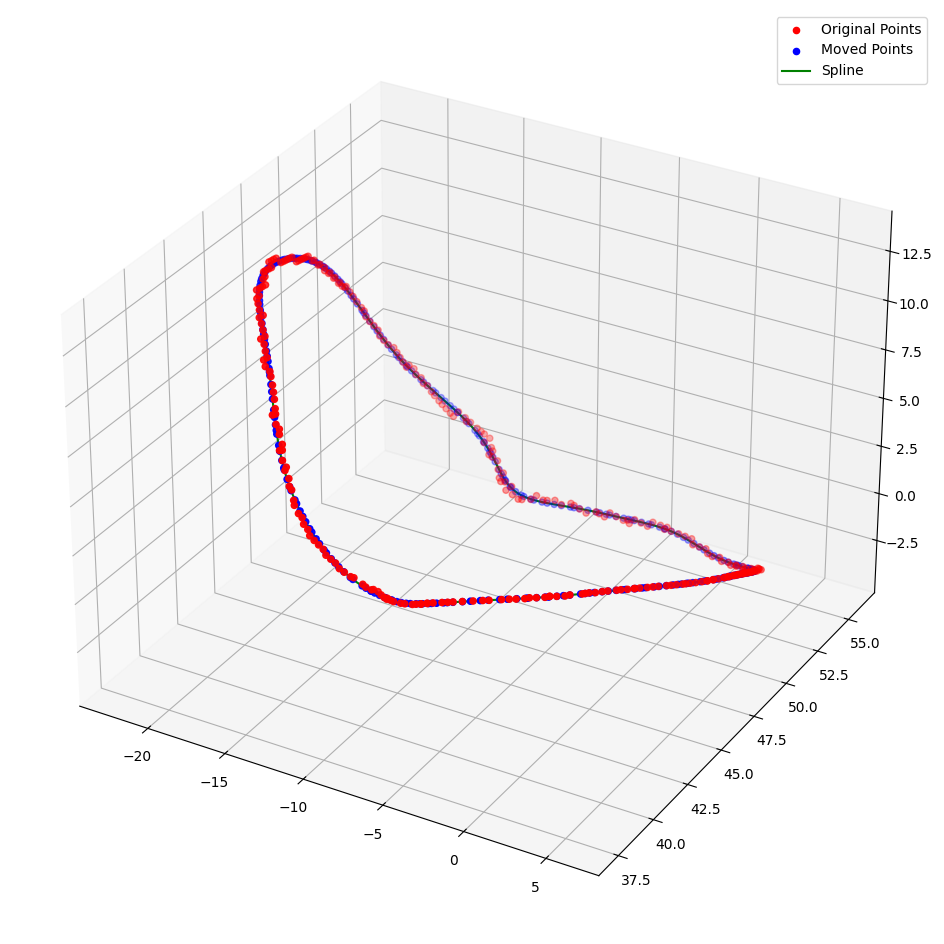

In [3]:
from scipy.interpolate import splprep, splev
import matplotlib.pyplot as plt
import numpy as np
points = [[1.687993049621582, 40.078208923339844, 4.299842834472656], [1.7301275730133057, 39.6976432800293, 4.516809463500977], [1.3208484649658203, 39.58326721191406, 4.470519542694092], [0.8420296311378479, 39.65375518798828, 4.301836967468262], [0.8826949596405029, 39.281829833984375, 4.519035339355469], [0.4638330936431885, 39.16345977783203, 4.473377227783203], [-0.004771143663674593, 39.22968673706055, 4.304923057556152], [-0.38845324516296387, 39.13450622558594, 4.253908157348633], [-0.8121722936630249, 38.764808654785156, 4.358894348144531], [-1.2014048099517822, 38.771263122558594, 4.247718811035156], [-1.659603238105774, 38.62553024291992, 4.2064666748046875], [-2.0612006187438965, 38.35392379760742, 4.262084484100342], [-2.50703763961792, 38.21857833862305, 4.218898296356201], [-2.7779183387756348, 38.15635299682617, 4.17818021774292], [-2.923794746398926, 37.93699645996094, 4.2791643142700195], [-3.354468584060669, 37.81261444091797, 4.232488632202148], [-3.65909481048584, 37.74497985839844, 4.187150478363037], [-3.791475772857666, 37.898681640625, 4.039553642272949], [-4.212357997894287, 37.94768524169922, 3.881526470184326], [-4.360572338104248, 38.10913848876953, 3.7207255363464355], [-4.6256184577941895, 38.06366729736328, 3.6858952045440674], [-5.0493340492248535, 38.27393341064453, 3.4246158599853516], [-5.473049163818359, 38.22254943847656, 3.3866820335388184], [-5.896764755249023, 38.402000427246094, 3.1889758110046387], [-6.320484161376953, 38.38935089111328, 3.1755189895629883], [-6.744199275970459, 38.396324157714844, 3.1785383224487305], [-6.744199275970459, 38.644012451171875, 2.9666802883148193], [-7.167914390563965, 38.666282653808594, 2.9872920513153076], [-7.167914390563965, 38.87813949584961, 2.8053038120269775], [-7.591629981994629, 38.920066833496094, 2.840959310531616], [-8.010181427001953, 39.16434860229492, 2.7385005950927734], [-8.14797592163086, 39.00699996948242, 2.9141485691070557], [-8.03315544128418, 38.75932312011719, 3.09608793258667], [-8.20081615447998, 38.562782287597656, 3.320770740509033], [-8.439064979553223, 38.61602020263672, 3.369159698486328], [-8.862780570983887, 38.48860168457031, 3.6781153678894043], [-8.862780570983887, 38.27674102783203, 3.872313976287842], [-9.097268104553223, 38.11510467529297, 4.146509647369385], [-9.244644165039062, 37.94784927368164, 4.399135112762451], [-9.58348274230957, 38.06307601928711, 4.520130634307861], [-9.72790241241455, 37.906227111816406, 4.782793045043945], [-9.872323989868164, 37.749385833740234, 5.0491838455200195], [-10.170652389526367, 37.8858757019043, 5.185802459716797], [-10.311491012573242, 37.73988342285156, 5.465517044067383], [-10.445096969604492, 37.600242614746094, 5.747994422912598], [-10.583877563476562, 37.46711349487305, 6.037472248077393], [-10.843521118164062, 37.61646270751953, 6.184475898742676], [-10.98038101196289, 37.497154235839844, 6.492988586425781], [-11.22738265991211, 37.66032409667969, 6.652205944061279], [-11.302003860473633, 37.508914947509766, 6.936189651489258], [-11.517207145690918, 37.47865295410156, 7.311966419219971], [-11.681395530700684, 37.60988998413086, 7.436117649078369], [-11.980313301086426, 37.798423767089844, 7.761321544647217], [-12.036981582641602, 37.7114372253418, 7.980626106262207], [-12.255779266357422, 37.915096282958984, 8.181639671325684], [-12.396031379699707, 37.8219108581543, 8.608753204345703], [-12.518634796142578, 38.03376770019531, 8.608753204345703], [-12.606316566467285, 37.8896598815918, 9.00947380065918], [-12.79948616027832, 37.91440963745117, 9.438817977905273], [-12.871007919311523, 38.160255432128906, 9.285993576049805], [-13.01894474029541, 38.31733322143555, 9.438817977905273], [-13.2127046585083, 38.34357452392578, 9.871711730957031], [-13.347847938537598, 38.48646545410156, 10.00749397277832], [-13.410259246826172, 38.34357452392578, 10.314708709716797], [-13.61807632446289, 38.34254455566406, 10.727860450744629], [-13.697349548339844, 38.62049865722656, 10.586969375610352], [-13.855979919433594, 38.762962341308594, 10.727860450744629], [-14.138710021972656, 39.01116180419922, 10.971435546875], [-14.3677396774292, 39.19266128540039, 11.156057357788086], [-14.598920822143555, 39.3741569519043, 11.34067440032959], [-14.898340225219727, 39.58683776855469, 11.561878204345703], [-15.078864097595215, 39.71114730834961, 11.694522857666016], [-15.235384941101074, 39.58540725708008, 11.979057312011719], [-15.484111785888672, 39.74214553833008, 12.149726867675781], [-15.610304832458496, 40.083526611328125, 12.034952163696289], [-15.861233711242676, 40.23731994628906, 12.202661514282227], [-16.148698806762695, 40.459678649902344, 12.344974517822266], [-16.353437423706055, 40.459678649902344, 12.55683708190918], [-16.498043060302734, 40.870849609375, 12.413702011108398], [-16.758094787597656, 41.01453399658203, 12.57710075378418], [-17.040576934814453, 41.21263122558594, 12.7159423828125], [-17.30745506286621, 41.34770202636719, 12.874555587768555], [-17.442790985107422, 41.7308235168457, 12.73421859741211], [-17.6705322265625, 41.7308235168457, 12.946077346801758], [-17.96630859375, 41.95101547241211, 13.063512802124023], [-18.203271865844727, 42.117164611816406, 13.159696578979492], [-18.35699462890625, 42.41655349731445, 13.093376159667969], [-18.635953903198242, 42.54356002807617, 13.24695110321045], [-18.75155258178711, 42.873374938964844, 13.118049621582031], [-18.868268966674805, 43.155853271484375, 13.014604568481445], [-18.990449905395508, 43.47517395019531, 12.88359260559082], [-19.269559860229492, 43.60718536376953, 13.03505802154541], [-19.42875099182129, 43.887271881103516, 12.961584091186523], [-19.674455642700195, 44.053749084472656, 13.051875114440918], [-19.775165557861328, 44.273128509521484, 12.96323013305664], [-19.929494857788086, 44.64183807373047, 12.802127838134766], [-20.054853439331055, 44.94813537597656, 12.66663932800293], [-20.341421127319336, 45.07977294921875, 12.811944007873535], [-20.469192504882812, 45.379817962646484, 12.67477035522461], [-20.60621452331543, 45.66229248046875, 12.552560806274414], [-20.73822593688965, 45.95636749267578, 12.412235260009766], [-20.5877628326416, 46.10585403442383, 12.142953872680664], [-20.723018646240234, 46.39521789550781, 12.002171516418457], [-20.858278274536133, 46.68395233154297, 11.86137866973877], [-21.000545501708984, 46.9664306640625, 11.728769302368164], [-21.1379451751709, 47.25083923339844, 11.58666706085205], [-21.275348663330078, 47.53703689575195, 11.444561004638672], [-21.132795333862305, 47.68031311035156, 11.168315887451172], [-21.272720336914062, 47.96272277832031, 11.026483535766602], [-21.41690444946289, 48.245208740234375, 10.885571479797363], [-21.559772491455078, 48.52410125732422, 10.741674423217773], [-21.70263671875, 48.80139923095703, 10.597771644592285], [-21.853160858154297, 49.08388137817383, 10.449480056762695], [-21.99936866760254, 49.35582733154297, 10.302602767944336], [-21.863088607788086, 49.497676849365234, 10.011270523071289], [-22.012470245361328, 49.767372131347656, 9.864997863769531], [-21.879377365112305, 49.905479431152344, 9.5624418258667], [-22.032136917114258, 50.17182922363281, 9.417444229125977], [-21.87555694580078, 50.33113098144531, 9.032468795776367], [-22.087413787841797, 50.536685943603516, 9.032468795776367], [-21.949886322021484, 50.675819396972656, 8.674004554748535], [-22.110700607299805, 50.939613342285156, 8.531091690063477], [-21.99105453491211, 51.05876922607422, 8.19539737701416], [-22.15389060974121, 51.320709228515625, 8.054510116577148], [-22.035423278808594, 51.43722152709961, 7.703649044036865], [-22.199447631835938, 51.698516845703125, 7.56494140625], [-22.124980926513672, 51.77663040161133, 7.337601184844971], [-22.24342918395996, 52.0782470703125, 7.078052520751953], [-22.402585983276367, 52.34187316894531, 6.938312530517578], [-22.279268264770508, 52.46326446533203, 6.609714031219482], [-22.174320220947266, 52.57512664794922, 6.327236652374268], [-22.040538787841797, 52.69683074951172, 6.009363174438477], [-21.88071060180664, 52.84857177734375, 5.642733097076416], [-21.791610717773438, 52.95243835449219, 5.423871040344238], [-21.53607177734375, 52.793983459472656, 5.263912677764893], [-21.393394470214844, 52.91801834106445, 4.970267295837402], [-21.27585220336914, 53.083839416503906, 4.6877899169921875], [-21.120492935180664, 53.21320343017578, 4.403273105621338], [-20.874237060546875, 53.060081481933594, 4.236483097076416], [-20.714265823364258, 53.18858337402344, 3.9594016075134277], [-20.554290771484375, 53.317100524902344, 3.6936986446380615], [-20.435874938964844, 53.59490203857422, 3.397494077682495], [-20.224018096923828, 53.59490203857422, 3.177332878112793], [-20.01799774169922, 53.59490203857422, 2.965474843978882], [-19.806140899658203, 53.59490203857422, 2.7513909339904785], [-19.593734741210938, 53.59490203857422, 2.5395331382751465], [-19.650806427001953, 53.84347915649414, 2.4814260005950928], [-19.463302612304688, 53.998207092285156, 2.2435250282287598], [-19.217899322509766, 53.870452880859375, 2.0654547214508057], [-19.022964477539062, 54.03993225097656, 1.8345296382904053], [-18.77596664428711, 53.92694091796875, 1.6557326316833496], [-18.624143600463867, 54.0483512878418, 1.493043065071106], [-18.318462371826172, 54.018619537353516, 1.2550190687179565], [-18.106605529785156, 54.018619537353516, 1.094299077987671], [-17.813087463378906, 54.018619537353516, 0.8824410438537598], [-17.601228713989258, 54.018619537353516, 0.734984815120697], [-17.337106704711914, 54.018619537353516, 0.566523551940918], [-17.05203628540039, 54.018619537353516, 0.38966798782348633], [-16.840179443359375, 54.018619537353516, 0.2685706317424774], [-16.88957405090332, 54.44233703613281, 0.24450770020484924], [-16.451637268066406, 54.4584846496582, 0.015534603036940098], [-16.261062622070312, 54.32801818847656, -0.06927179545164108], [-16.09827423095703, 54.4584846496582, -0.15577392280101776], [-15.642242431640625, 54.44233703613281, -0.3594343066215515], [-15.36950397491455, 54.44233703613281, -0.47597113251686096], [-15.157642364501953, 54.44233703613281, -0.5618728995323181], [-14.79481029510498, 54.44233703613281, -0.7047756910324097], [-14.79481029510498, 54.018619537353516, -0.6746988296508789], [-14.332077026367188, 54.04570770263672, -0.8522214889526367], [-14.133679389953613, 53.922523498535156, -0.9156261682510376], [-14.091093063354492, 53.59490203857422, -0.900512158870697], [-13.879236221313477, 53.59490203857422, -0.9753409624099731], [-13.523660659790039, 53.59490203857422, -1.0989450216293335], [-13.099946022033691, 53.171180725097656, -1.1939361095428467], [-12.760225296020508, 53.171180725097656, -1.3066883087158203], [-12.650678634643555, 52.7529296875, -1.2851498126983643], [-12.427680969238281, 52.6153450012207, -1.3369126319885254], [-12.272870063781738, 52.7529296875, -1.4065070152282715], [-11.828795433044434, 52.747459411621094, -1.546748399734497], [-11.828795433044434, 52.32374954223633, -1.478744626045227], [-11.405080795288086, 52.32374954223633, -1.6104586124420166], [-10.984201431274414, 52.2857666015625, -1.7329883575439453], [-10.84485149383545, 52.401702880859375, -1.795304775238037], [-10.557645797729492, 52.747459411621094, -1.940380573272705], [-10.557645797729492, 53.171180725097656, -2.007211685180664], [-10.117450714111328, 53.163108825683594, -2.141404628753662], [-9.96522331237793, 53.298973083496094, -2.2092645168304443], [-9.710214614868164, 53.59490203857422, -2.3320469856262207], [-9.286495208740234, 53.59490203857422, -2.4606189727783203], [-9.017086029052734, 54.018619537353516, -2.6029038429260254], [-8.805228233337402, 54.018619537353516, -2.6645565032958984], [-8.439064979553223, 54.018619537353516, -2.7692794799804688], [-8.015348434448242, 54.018619537353516, -2.8863677978515625], [-7.725513458251953, 54.44233703613281, -3.0233230590820312], [-7.513655662536621, 54.44233703613281, -3.077455759048462], [-7.167914390563965, 54.44233703613281, -3.163034677505493], [-7.167914390563965, 54.866050720214844, -3.22149658203125], [-6.744199275970459, 54.866050720214844, -3.321953773498535], [-6.298411846160889, 54.877777099609375, -3.421077251434326], [-6.142459869384766, 55.02684020996094, -3.4741530418395996], [-5.9018659591674805, 54.877777099609375, -3.5009965896606445], [-5.896764755249023, 55.289764404296875, -3.557828903198242], [-5.473049163818359, 55.289764404296875, -3.6386542320251465], [-5.0493340492248535, 55.289764404296875, -3.712191104888916], [-5.0493340492248535, 55.71348571777344, -3.768813133239746], [-4.586076736450195, 55.7528076171875, -3.845193386077881], [-4.201899528503418, 55.604591369628906, -3.877331256866455], [-4.201899528503418, 55.81645202636719, -3.905796527862549], [-3.8197269439697266, 55.67180633544922, -3.9328365325927734], [-3.354468584060669, 55.71348571777344, -3.9870290756225586], [-2.930752992630005, 55.71348571777344, -4.023443222045898], [-2.50703763961792, 55.71348571777344, -4.051992416381836], [-2.0833187103271484, 55.289764404296875, -3.9997451305389404], [-1.659603238105774, 55.289764404296875, -4.008957386016846], [-1.2358877658843994, 55.289764404296875, -4.009954452514648], [-0.8121722936630249, 54.91416549682617, -3.925379753112793], [-0.38845324516296387, 54.75040054321289, -3.8692703247070312], [0.035262227058410645, 54.81345748901367, -3.853731632232666], [0.45897769927978516, 54.44233703613281, -3.720883369445801], [0.8826949596405029, 54.44233703613281, -3.6675057411193848], [1.3064104318618774, 54.109004974365234, -3.504303455352783], [1.5866334438323975, 54.190208435058594, -3.480015993118286], [1.728775978088379, 54.036827087402344, -3.4026665687561035], [2.1538431644439697, 54.018619537353516, -3.306154727935791], [2.5775604248046875, 53.69554138183594, -3.0858535766601562], [2.5775604248046875, 53.483680725097656, -3.0041608810424805], [2.981341600418091, 53.62207794189453, -2.9455628395080566], [3.4249930381774902, 53.59490203857422, -2.801340103149414], [3.4249930381774902, 53.279884338378906, -2.664998769760132], [3.6596813201904297, 53.366485595703125, -2.627180814743042], [3.820035934448242, 53.203617095947266, -2.4975168704986572], [3.835541248321533, 52.74782180786133, -2.277843952178955], [3.9679975509643555, 52.60681915283203, -2.161134958267212], [4.286031723022461, 52.74782180786133, -2.1106534004211426], [4.283367156982422, 52.30601119995117, -1.8883614540100098], [4.1494221687316895, 52.041629791259766, -1.8077749013900757], [4.283367156982422, 51.90024948120117, -1.681221842765808], [4.720644474029541, 51.871673583984375, -1.486219048500061], [4.5957417488098145, 51.599449157714844, -1.3950159549713135], [4.720644474029541, 51.46544647216797, -1.2719104290008545], [4.708260536193848, 51.03507614135742, -1.0489548444747925], [4.857577323913574, 50.88214874267578, -0.9029028415679932], [4.708260536193848, 50.62592315673828, -0.8329330086708069], [5.138655185699463, 50.60558319091797, -0.6346019506454468], [5.009950160980225, 50.33320617675781, -0.5455193519592285], [5.138655185699463, 50.19725036621094, -0.41794466972351074], [5.1278157234191895, 49.76747131347656, -0.19603869318962097], [5.274360656738281, 49.616912841796875, -0.05254608392715454], [5.571906089782715, 49.76747131347656, -0.0062529463320970535], [5.561672210693359, 49.33452606201172, 0.21660791337490082], [5.432497978210449, 49.06507873535156, 0.3037244379520416], [5.561672210693359, 48.92790985107422, 0.4296315312385559], [5.55192232131958, 48.494407653808594, 0.6526153087615967], [5.698725700378418, 48.342567443847656, 0.7932325601577759], [6.002126693725586, 48.494407653808594, 0.8336206674575806], [5.9932637214660645, 48.05596923828125, 1.0584615468978882], [5.869340419769287, 47.79204559326172, 1.1496050357818604], [5.9932637214660645, 47.65563201904297, 1.269417405128479], [5.979433059692383, 47.217227935791016, 1.4969861507415771], [5.846288681030273, 46.96516036987305, 1.5833303928375244], [5.979433059692383, 46.82052230834961, 1.7109401226043701], [5.958010196685791, 46.38162612915039, 1.9422444105148315], [6.093066215515137, 46.233665466308594, 2.0708022117614746], [5.958010196685791, 45.989288330078125, 2.1592001914978027], [5.925546169281006, 45.55005645751953, 2.3954267501831055], [5.756479740142822, 45.331817626953125, 2.464508295059204], [5.54357385635376, 45.27068328857422, 2.4282665252685547], [5.54357385635376, 45.05882263183594, 2.553067684173584], [5.22664737701416, 44.968231201171875, 2.5008797645568848], [5.099188804626465, 44.726688385009766, 2.6029698848724365], [5.119858741760254, 44.375205993652344, 2.822340965270996], [4.851551055908203, 44.091583251953125, 2.9070141315460205], [4.704644203186035, 43.86417007446289, 2.9956789016723633], [4.696141242980957, 43.48276138305664, 3.2204811573028564], [4.312527656555176, 43.38446807861328, 3.159274101257324], [4.19802188873291, 43.142887115478516, 3.2697267532348633], [4.312527656555176, 43.00178527832031, 3.388394832611084], [4.264930248260498, 42.5600700378418, 3.6318321228027344], [3.809382677078247, 42.61903762817383, 3.4620509147644043], [3.8487086296081543, 42.26870346069336, 3.6795473098754883], [3.5588831901550293, 41.98279571533203, 3.7592458724975586], [3.420583724975586, 41.753570556640625, 3.848475694656372], [3.385005474090576, 41.30522537231445, 4.08812141418457], [3.0012755393981934, 41.30710983276367, 3.9797401428222656], [3.0012755393981934, 41.03965377807617, 4.12911319732666], [3.0012755393981934, 40.827796936035156, 4.244368553161621], [2.535933017730713, 40.50168228149414, 4.296525001525879], [2.5775604248046875, 40.115966796875, 4.5139055252075195], [2.1723341941833496, 40.00526809692383, 4.468325138092041], [1.687993049621582, 40.078208923339844, 4.299842834472656]]
x = np.array([i[0] for i in points])
y = np.array([i[1] for i in points])
z = np.array([i[2] for i in points])

dist = np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2)
t = np.insert(np.cumsum(dist), 0, 0)
tck, u = splprep([x, y, z], u=t, per=True, s=10)
new_t = np.linspace(0, t[-1], 1000)  
new_points = splev(new_t, tck)
new_x, new_y, new_z = new_points
print([np.array([new_x[i], new_y[i], new_z[i]]) for i in range(len(new_z))])
closest_indices = [np.argmin((new_x - x[i])**2 + (new_y - y[i])**2 + (new_z - z[i])**2) for i in range(len(x))]
print(closest_indices)
moved_x = new_x[closest_indices]
moved_y = new_y[closest_indices]
moved_z = new_z[closest_indices]


fig = plt.figure(figsize=(24,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, color='red', label='Original Points')
ax.scatter(moved_x, moved_y, moved_z, color='blue', label='Moved Points')
ax.plot(new_x, new_y, new_z, color='green', label='Spline')
ax.legend()
plt.show()


In [18]:
points = [np.array([1,2,3])]
print(", ".join([str(list(x)) for x in points]))

[1, 2, 3]


In [72]:
import numpy as np
import pyvista as pv
points = np.random.random((10, 3))
pl = pv.Plotter()
actor = pl.add_points(
    points, render_points_as_spheres=False, point_size=100.0
)
pl.show()

Widget(value="<iframe src='http://localhost:64776/index.html?ui=P_0x24cecb53760_49&reconnect=auto' style='widt…

In [76]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
from vtkbool.vtkBool import vtkPolyDataBooleanFilter
mesh1 = pv.read('imageAnalysisGeneration/connectorStruct.stl')

sphere_a = pv.Sphere(radius=120)
result = sphere_a.boolean_difference(mesh1)
pl = pv.Plotter()
_ = pl.add_mesh(sphere_a, color='r', style='wireframe', line_width=3)
_ = pl.add_mesh(result, color='lightblue')
_ = pl.add_mesh(mesh1)
pl.camera_position = 'xz'
pl.show()

Widget(value="<iframe src='http://localhost:50508/index.html?ui=P_0x2995a05f5b0_105&reconnect=auto' style='wid…

In [1]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
mesh = pv.read('finalSocket.stl')
from pyvista import examples
# mesh = examples.load_random_hills()
import matplotlib.pyplot as plt

def normalizeToUnitBox(mesh):
    bounds = mesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = mesh.center
    meshCentered = mesh.translate(-np.array(center), inplace=False)
    meshScaled = meshCentered.scale(1 / max_length, inplace=False)
    return meshScaled
normalizedMesh = normalizeToUnitBox(mesh)

meanCurvatures = normalizedMesh.curvature(curv_type="Mean")
normalizedMesh["meanCurvatures"] = meanCurvatures
normalizedMesh.plot(clim=[-1, 1], scalars='meanCurvatures', cmap="seismic")

Widget(value="<iframe src='http://localhost:50886/index.html?ui=P_0x1d4d3e0b8b0_0&reconnect=auto' style='width…

In [2]:
from tqdm import tqdm 

def orderNeighborsCyclicaly(mesh, vIdx):
    neighbors = normalizedMesh.point_neighbors(vIdx)
    v0=np.array(normalizedMesh.points[vIdx])
    orderedNeighbors = []
    currNeighborIndex = 0
    remainingNeighborIdx = normalizedMesh.point_neighbors(vIdx)
    while len(remainingNeighborIdx)>0:
        ray1 = mesh.points[currNeighborIndex] - v0
        ray2 = mesh.points[remainingNeighborIdx[0]] - v0
        smallestAngle = np.arccos(np.dot(ray1,ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
        nextCyclicNeighbor = remainingNeighborIdx[0]
        for testNeighborIdx in remainingNeighborIdx:
            ray2 = mesh.points[testNeighborIdx] - v0
            currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
            if currAngle < smallestAngle:
                smallestAngle = currAngle
                nextCyclicNeighbor = testNeighborIdx
        orderedNeighbors.append(nextCyclicNeighbor)
        remainingNeighborIdx.remove(nextCyclicNeighbor)
        currNeighborIndex = nextCyclicNeighbor
    return orderedNeighbors

def generateMeanValueCoordinates(mesh):
    meanValueCoordinates = {}
    for pointIdx in tqdm(range(len(normalizedMesh.points))):
        v0 = np.array(normalizedMesh.points[pointIdx])
        orderedNeighbors = orderNeighborsCyclicaly(normalizedMesh, pointIdx)
        weights = {}
        for idx in range(len(orderedNeighbors)):
            vi = np.array(normalizedMesh.points[orderedNeighbors[idx]])
            viplus1 = np.array(normalizedMesh.points[orderedNeighbors[(idx+1)%len(orderedNeighbors)]])
            viminus1 = np.array(normalizedMesh.points[orderedNeighbors[idx-1]])
            ray1 = vi - v0
            ray2 = viplus1 - v0
            ray3 = viminus1 - v0
            alphai = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
            alphaiminus1 = np.arccos(np.dot(ray1, ray3)/(np.linalg.norm(ray1)*np.linalg.norm(ray3)))
            weights[orderedNeighbors[idx]]= (np.tan(alphai/2) + np.tan(alphaiminus1/2))/np.linalg.norm(vi-v0)
        weightstotal = sum(weights)
        normalizedWeights = {neighborId: weight/weightstotal for neighborId, weight in weights.items()}
        meanValueCoordinates[pointIdx] = normalizedWeights
    return meanValueCoordinates

def createBaseTriangle(mesh):
    baseTriangle = {}
    baseTriangle[0] = mesh.points[0][:2]
    neighbors = orderNeighborsCyclicaly(mesh, 0)
    baseTriangle[neighbors[0]] = mesh.points[neighbors[0]][:2]
    baseTriangle[neighbors[1]] = mesh.points[neighbors[1]][:2]
    return baseTriangle

meanValueCoordinates = generateMeanValueCoordinates(normalizedMesh)
baseTriangle = createBaseTriangle(normalizedMesh)

  0%|          | 0/9864 [00:00<?, ?it/s]C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:12: RuntimeWarning: invalid value encountered in scalar divide
  smallestAngle = np.arccos(np.dot(ray1,ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:16: RuntimeWarning: invalid value encountered in scalar divide
  currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
 10%|▉         | 977/9864 [00:03<00:30, 287.60it/s]C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:16: RuntimeWarning: invalid value encountered in arccos
  currAngle = np.arccos(np.dot(ray1, ray2)/(np.linalg.norm(ray1)*np.linalg.norm(ray2)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.py:39: RuntimeWarning: invalid value encountered in arccos
  alphaiminus1 = np.arccos(np.dot(ray1, ray3)/(np.linalg.norm(ray1)*np.linalg.norm(ray3)))
C:\Users\Katie\AppData\Local\Temp\ipykernel_22220\892337525.p

{0: pyvista_ndarray([ 0.31738672, -0.3034697 ], dtype=float32), 1: pyvista_ndarray([ 0.32998025, -0.30780798], dtype=float32), 6: pyvista_ndarray([ 0.3304735 , -0.30244097], dtype=float32)}


In [28]:
new2d = {}
new2d.update(baseTriangle)

N = len(normalizedMesh.points)

A = lil_matrix((2*(N-3), 2*(N-3)))
b = np.zeros(2*(N-3))

for i in range(3, N): 
    for j, weight in meanValueCoordinates[i].items():
        if j in [0,1,2]:
            b[2*(i-3)] += weight * list(baseTriangle.values())[j-3][0] 
            b[2*(i-3)+1] += weight * list(baseTriangle.values())[j-3][1] 
        else:
            A[2*(i-3), 2*(j-3)] += weight 
            A[2*(i-3)+1, 2*(j-3)+1] += weight 

A = A.tocsr()
solution = spsolve(A, b)
# solution = np.linalg.lstsq(A, b)
x_coords = solution[::2]
y_coords = solution[1::2]
full_2D_positions = np.vstack([np.array(list(baseTriangle.values())), np.column_stack((x_coords, y_coords))])

[nan nan nan ... nan nan nan]


c:\Users\Katie\anaconda3\envs\prosthetics3.10\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:293: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


100%|██████████| 100/100 [00:00<00:00, 713.96it/s]


0.3173867166042328
0.3299802541732788
0.33047351241111755
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


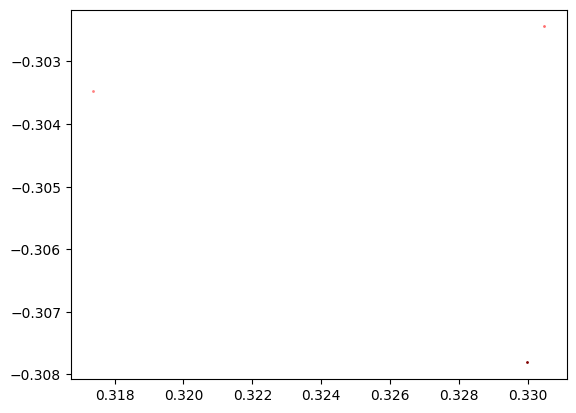

In [10]:
norm = mpl.colors.Normalize(vmin=-20, vmax=10)
cmap = cm.seismic
m = cm.ScalarMappable(norm=norm, cmap=cmap)
colors = [m.to_rgba(val) for val in meanCurvatures]
for i, point in enumerate(tqdm(full_2D_positions[:100])):
    plt.scatter(point[0], point[1], color = colors[i], s = 1)

In [44]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples

def normalizeToUnitBox(mesh):
    bounds = mesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = mesh.center
    meshCentered = mesh.translate(-np.array(center), inplace=False)
    meshScaled = meshCentered.scale(1 / max_length, inplace=False)
    return meshScaled

mesh = pv.read('atestforsomething.stl')
normalizedMesh = normalizeToUnitBox(mesh)
fingerVector = np.array([0,1,0])
normal = fingerVector / np.linalg.norm(fingerVector)
a = mesh.center + normal * mesh.length / 3.0
b = mesh.center - normal * mesh.length / 3.0
n_slices = 20
line = pv.Line(a, b, n_slices)
slices = pv.MultiBlock()
for point in line.points:
    slices.append(mesh.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmap = mpl.cm.get_cmap('Blues')
p = pv.Plotter()
p.add_mesh(mesh.outline())
for i in range(len(slices)):
    if len(slices[i].points) != 0:
        p.add_mesh(slices[i], opacity=1, color = cmap(norm(len(slices)-i)))
p.show()

C:\Users\Katie\AppData\Local\Temp\ipykernel_10592\839757694.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Blues')


Widget(value="<iframe src='http://localhost:63593/index.html?ui=P_0x24b9fc2e9e0_69&reconnect=auto' style='widt…

In [24]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
from tqdm import tqdm 

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
p = pv.Plotter()
# p.add_mesh(socketMesh)
p.add_mesh(fingersMesh)
fingerVector = [12,50,0]
origin = [0, 90, 0]
def selectTopPoints(mesh, fingerVector:list, origin:list):
    selectedPointId = []
    normal = np.array(fingerVector)
    normal = normal/np.linalg.norm(normal)
    for i, point in enumerate(mesh.points):
        if np.dot(np.array(point)-np.array(origin), normal) > 0:
            selectedPointId.append(i)
    return mesh.extract_points(selectedPointId)

def moveToClosestFinger(socketPortion, fingerMeshes):
    normals = socketPortion.point_normals
    for idx, point1 in enumerate(socketPortion.points):
        closestPoint = fingerMeshes.points[0]
        closestDistance = np.linalg.norm(np.array(closestPoint)-np.array(point1)) 
        for point2 in fingerMeshes.points:
            currDistance = np.linalg.norm(np.array(point2)-np.array(point1))
            if currDistance < closestDistance:
                closestPoint = point2
                closestDistance = currDistance
        u = np.array(point1)-np.array(closestPoint)
        v = np.array(normals[idx])
        proj = np.dot(u,v)/(np.lingalg.norm(v)**2)*np.v
        socketPortion.points[idx] = point1+proj

extracted = selectTopPoints(socketMesh, fingerVector, origin)
moveToClosestFinger(extracted, fingersMesh)
p.add_mesh(extracted)
p.show()

TypeError: SetPassThroughPointIds argument 1: 'list' object cannot be interpreted as an integer

In [2]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
from tqdm import tqdm 

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
fingerVector = [12,50,0]
def selectPoints(socketMesh, fingerVector:list, fingerJointOrigin:list):
    point, idx = socketMesh.ray_trace(fingerJointOrigin, [fingerJointOrigin[i]-fingerVector[i] for i in range(3)], first_point=True)
    selectingSphere = pv.Sphere(radius=5, center = point)
    # selectedPoints = socketMesh.extract_points(socketMesh.select_enclosed_points(selectingSphere)['SelectedPoints'].view(bool))
    selectedIds = socketMesh.select_enclosed_points(selectingSphere)['SelectedPoints'].view(bool)
    finalSelectedIDs = []
    for i in range(len(selectedIds)):
        if selectedIds[i]:
            if i > len(socketMesh.points)/2:
                finalSelectedIDs.append(i)
            else:
                print("BRUH")

    return socketMesh.extract_points(finalSelectedIDs)

def moveToClosestFinger(socketPortion, fingerMeshes):
    normals = socketPortion.point_normals
    for idx, point1 in enumerate(socketPortion.points):
        closestPoint = fingerMeshes.points[0]
        closestDistance = np.linalg.norm(np.array(closestPoint)-np.array(point1)) 
        for point2 in fingerMeshes.points:
            currDistance = np.linalg.norm(np.array(point2)-np.array(point1))
            if currDistance < closestDistance:
                closestPoint = point2
                closestDistance = currDistance
        u = np.array(point1)-np.array(closestPoint)
        v = np.array(normals[idx])
        proj = np.dot(u,v)/(np.lingalg.norm(v)**2)*np.v
        socketPortion.points[idx] = point1+proj

extracted = selectPoints(socketMesh, fingerVector, fingersMesh.center)
print(extracted)
# moveToClosestFinger(extracted, fingersMesh)
# p.add_mesh(extracted)
p = pv.Plotter()
p.add_mesh(socketMesh, style = "wireframe")
p.add_mesh(fingersMesh)
p.add_points(extracted, color = "g")
p.show()

UnstructuredGrid (0x1d4bf185c00)
  N Cells:    1283
  N Points:   711
  X Bounds:   -1.676e+01, -6.111e+00
  Y Bounds:   9.350e+01, 9.859e+01
  Z Bounds:   -3.036e+01, -1.957e+01
  N Arrays:   2


Widget(value="<iframe src='http://localhost:54934/index.html?ui=P_0x1d4bafe7f40_1&reconnect=auto' style='width…

In [13]:
totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
smooth = totalMesh.smooth_taubin(n_iter=100, pass_band = 0.5)
smooth.plot()

Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281e07f9360_7&reconnect=auto' style='width…

In [7]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples
totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
def normalizeToUnitBox(totalMesh, socketMesh, fingerMesh):
    bounds = totalMesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = totalMesh.center
    totalMeshCentered = totalMesh.translate(-np.array(center), inplace=False)
    totalMeshScaled = totalMeshCentered.scale(1 / max_length, inplace=False)

    socketMeshCentered = socketMesh.translate(-np.array(center), inplace=False)
    socketMeshScaled = socketMeshCentered.scale(1 / max_length, inplace=False)

    fingerMeshCentered = fingerMesh.translate(-np.array(center), inplace=False)
    fingerMeshScaled = fingerMeshCentered.scale(1 / max_length, inplace=False)
    return [totalMeshScaled, socketMeshScaled, fingerMeshScaled]

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")

normalizedTotal, normalizedSocket, normalizedFingers  = normalizeToUnitBox(totalMesh, socketMesh, fingersMesh)
fingerVector = np.array([0,1,0])
normal = fingerVector / np.linalg.norm(fingerVector)
a = normalizedTotal.center + normal * normalizedTotal.length / 3.0
b = normalizedTotal.center - normal * normalizedTotal.length / 3.0
n_slices = 100
line = pv.Line(a, b, n_slices)
slicesSocket = pv.MultiBlock()
slicesFingers = pv.MultiBlock()
for point in line.points:
    slicesSocket.append(normalizedSocket.slice(normal=normal, origin=point))
    slicesFingers.append(normalizedFingers.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmapSocket = mpl.cm.get_cmap('Blues')
cmapFinger = mpl.cm.get_cmap('Reds')
p = pv.Plotter()
for i in range(n_slices):
    if len(slicesSocket[i].points) != 0:
        p.add_mesh(slicesSocket[i], opacity=1, color = cmapSocket(norm(n_slices-i)))
    if len(slicesFingers[i].points) != 0:
        p.add_mesh(slicesFingers[i], opacity=1, color = cmapFinger(norm(n_slices-i)))

p.camera_position = [(0,2,0), (0,0,0), (0,0,-1)]
p.camera_set = True 
p.show()
p.screenshot('testimage3.png')

C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\2942321406.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapSocket = mpl.cm.get_cmap('Blues')
C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\2942321406.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapFinger = mpl.cm.get_cmap('Reds')


Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281b8df6890_2&reconnect=auto' style='width…

pyvista_ndarray([[[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 ...,

                 [[255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [255, 255, 255]],

                 [[255, 255, 255],
  

In [14]:
p = pv.Plotter()
thing= pv.Plane()
p.add_mesh(thing)
p.show()

Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281e05d2e60_8&reconnect=auto' style='width…

In [6]:
import pyvista as pv
import numpy as np
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from pyvista import examples

def normalizeToUnitBox(totalMesh, socketMesh, fingerMesh):
    bounds = totalMesh.bounds
    xlen = bounds[1] - bounds[0]
    ylen = bounds[3] - bounds[2]
    zlen = bounds[5] - bounds[4]
    max_length = max(xlen, ylen, zlen)
    center = totalMesh.center
    totalMeshCentered = totalMesh.translate(-np.array(center), inplace=False)
    totalMeshScaled = totalMeshCentered.scale(1 / max_length, inplace=False)

    socketMeshCentered = socketMesh.translate(-np.array(center), inplace=False)
    socketMeshScaled = socketMeshCentered.scale(1 / max_length, inplace=False)

    fingerMeshCentered = fingerMesh.translate(-np.array(center), inplace=False)
    fingerMeshScaled = fingerMeshCentered.scale(1 / max_length, inplace=False)
    return [totalMeshScaled, socketMeshScaled, fingerMeshScaled]

totalMesh = pv.read("imageAnalysisGeneration/totalStruct.stl")
socketMesh = pv.read("imageAnalysisGeneration/socketStruct.stl")
fingersMesh = pv.read("imageAnalysisGeneration/fingerStruct.stl")
# mesh = pv.read('firsttestofnewmissinggeo.stl')
normalizedTotal, normalizedSocket, normalizedFingers  = normalizeToUnitBox(totalMesh, socketMesh, fingersMesh)
fingerVector = [0,1,0]
normal = np.array(fingerVector) / np.linalg.norm(np.array(fingerVector))
a = normalizedTotal.center + normal * normalizedTotal.length / 3.0
b = normalizedTotal.center - normal * normalizedTotal.length / 3.0


xSlices = 8
ySlices = 8

n_slices = xSlices*ySlices
line = pv.Line(a, b, n_slices)
slicesSocket = pv.MultiBlock()
slicesFingers = pv.MultiBlock()
for point in line.points:
    slicesSocket.append(normalizedSocket.slice(normal=normal, origin=point))
    slicesFingers.append(normalizedFingers.slice(normal=normal, origin=point))

norm = mpl.colors.Normalize(vmin=0, vmax=n_slices)
cmap = mpl.cm.get_cmap('Blues')
p = pv.Plotter()
p.add_mesh(normalizedTotal.outline())

p = pv.Plotter(shape=(xSlices, ySlices))
for x in range(xSlices):
    for y in range(ySlices):
        p.subplot(x, y)
        if len(slicesSocket[x*ySlices + y].points) != 0:
            # p.add_mesh(slices[x*ySlices + y], opacity=1, color = cmap(norm(len(slices)-(x*ySlices + y))))
            p.add_mesh(slicesSocket[x*ySlices + y], opacity=1, color = "Blue")
        if len(slicesFingers[x*ySlices + y].points) != 0:
            p.add_mesh(slicesFingers[x*ySlices + y], opacity=1, color = "Red")
        p.add_text(f"Layer: {(x)*(ySlices)+(y+1)}", font_size=12)
        p.camera_position = [(0,1,0), (0,0,0), (0,0,-1)]
        p.camera_set = True 

p.show()
p.screenshot('testimage2.png')

C:\Users\Katie\AppData\Local\Temp\ipykernel_2416\4227212618.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('Blues')


Widget(value="<iframe src='http://localhost:55650/index.html?ui=P_0x281da37d300_1&reconnect=auto' style='width…

pyvista_ndarray([[[  0,   0,   0],
                  [  0,   0,   0],
                  [  0,   0,   0],
                  ...,
                  [  0,   0,   0],
                  [  0,   0,   0],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 ...,

                 [[  0,   0,   0],
                  [255, 255, 255],
                  [255, 255, 255],
                  ...,
                  [255, 255, 255],
                  [255, 255, 255],
                  [  0,   0,   0]],

                 [[  0,   0,   0],
  